# Set up 


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
import scipy.optimize as optimize
import threading
from scipy.optimize import LinearConstraint
from datetime import datetime
import tensorflow as tf
import tensorflow_probability as tfp


In [2]:
path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)

df = df[df["FileCondi"]!="CMat"]
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_giver = df
df0=df.copy()# = df.copy()
# df_giver.columns=df_giver.columns.droplevel(1)
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

df_err = df_err.reset_index()
df_crt = df_crt.reset_index()
# df_err.reindex(np.arange(1,df_err.shape[0]))
# df_crt.reindex(np.arange(1,df_crt.shape[0]))

# R funcitons

In [3]:
%get df_giver --from Python3
# library(plyr)
library(dplyr)
library(ggplot2)
library(lattice)
library(Rmisc)
library(stringr)
library(tidyr)
library(cowplot)
library(plotly)
# source("functions_fromr.r")
d=df_giver


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: 'cowplot'


The following object is masked from 'package:ggplot2':

    ggsave



Attaching package: 'plotly'


The following objects are masked from 'package:plyr':

    arrange, mutate, rename, summarise


The following object is mas

   Length     Class      Mode 
      168 character character 

Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 56 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 56 rows containing missing values (geom_errorbar)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



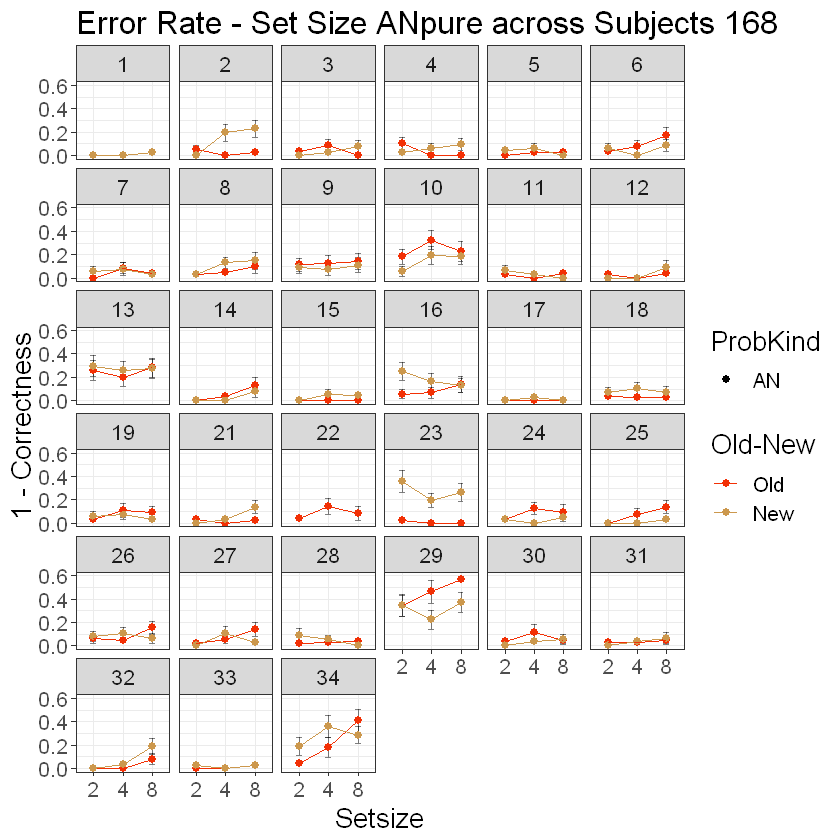

Warning message:
"Removed 106 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



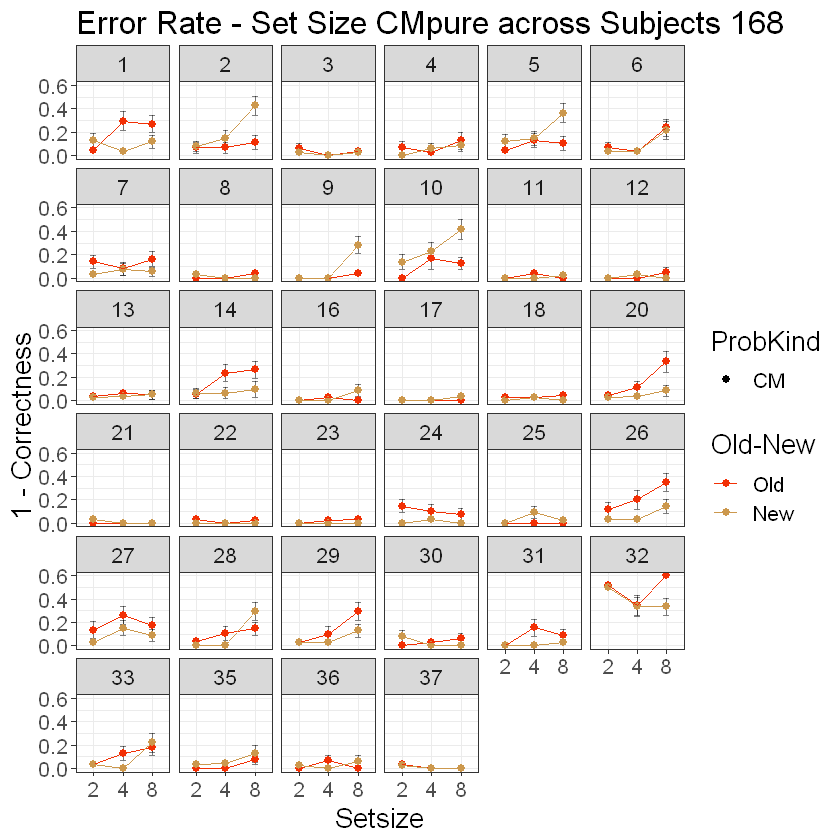

Warning message:
"Removed 115 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
Automatically converting the following non-factors to factors: Subnum, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



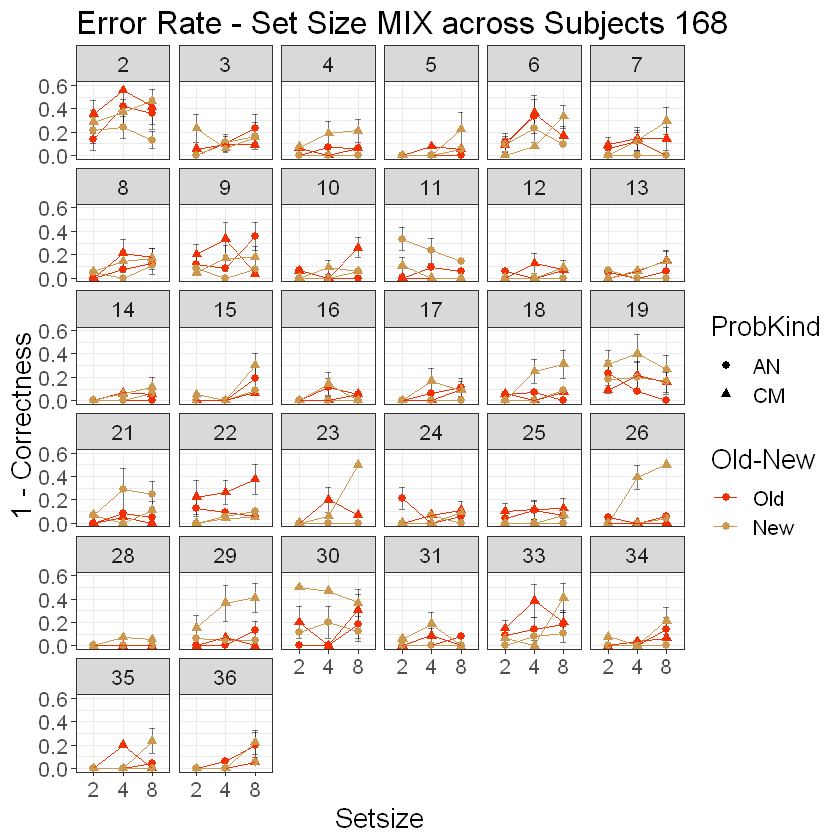

Warning message:
"Removed 36 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


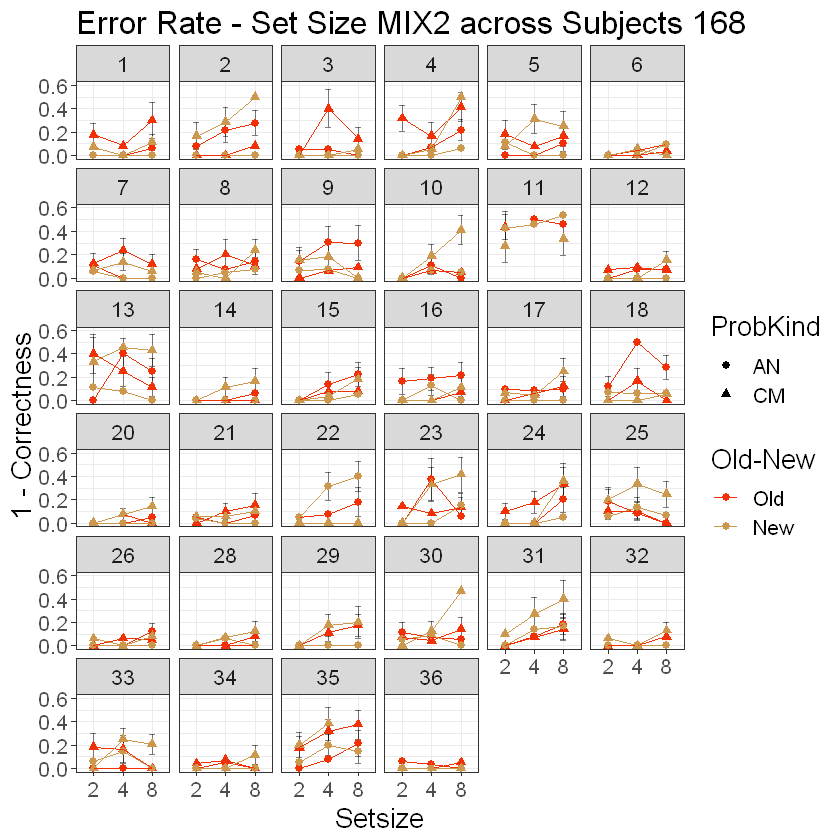

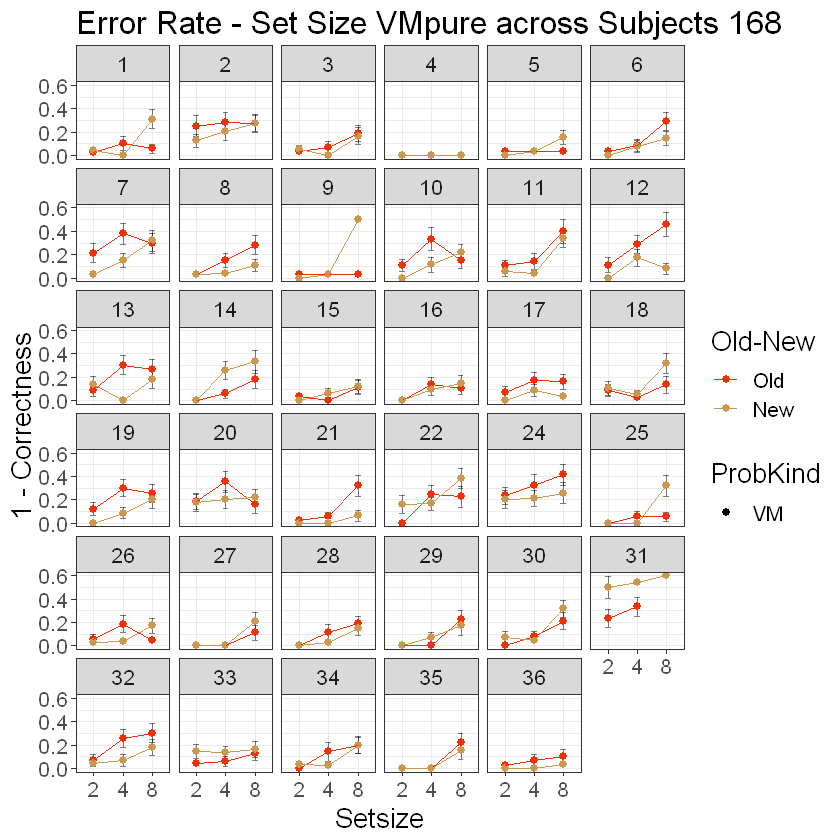

In [7]:
dx=d%>%group_by(Subnum,FileCondi) %>%dplyr::summarise(n())
summary(dx$FileCondi)
all_subnum=length(dx$Subnum)
p.ERdif=function(condition,d){
  tit=paste(condition,'across Subjects',all_subnum)
  d0= d%>% filter(FileCondi==condition)
  dase=summarySEwithin(data=d0,measurevar = "Correctness",withinvars =
                         c("Subnum","Old","Setsize","Stimkind"))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,1-Correctness))+
    geom_errorbar(aes(ymin=(1-Correctness)-se, ymax=(1-Correctness)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=2)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Error Rate - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    # ylim(700,1550)+
  facet_wrap(Subnum~.)+
    scale_y_continuous("Probability of Error")+
    ylim(c(0,0.6))
    print(p)
  
   return (p)
}
for( iname in levels(as.factor(d$FileCondi))){
#     print(iname)
    p.ERdif(iname,d) #11.... 
}

#ANpure : 29, 34?
#CMpure: 32?
#Mix2: 11
#VMpure 31



Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 16 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 12 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



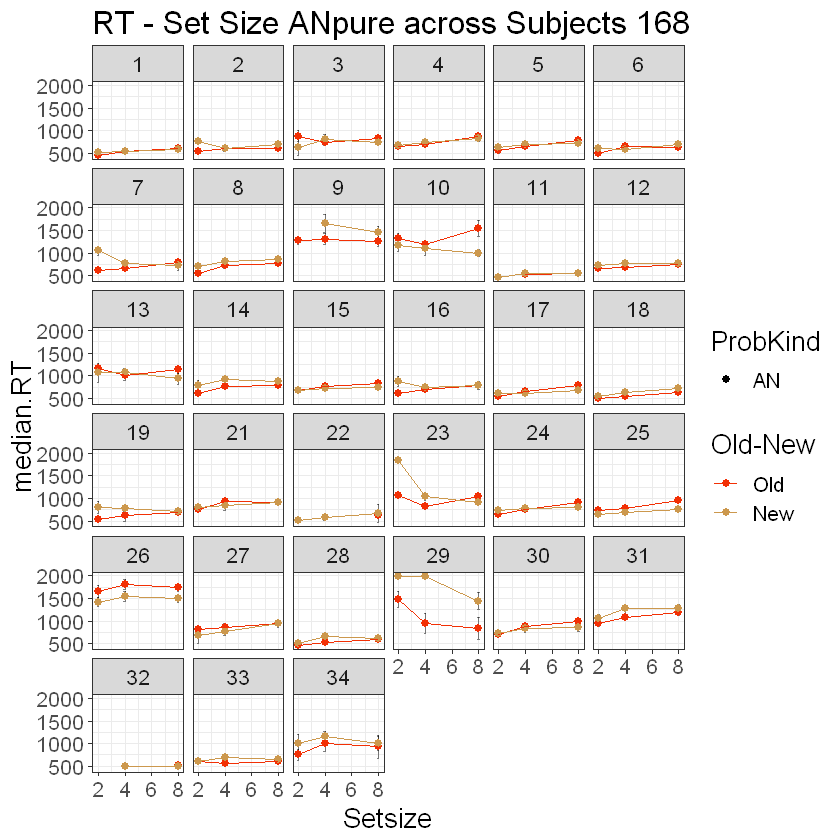

Warning message:
"Removed 18 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



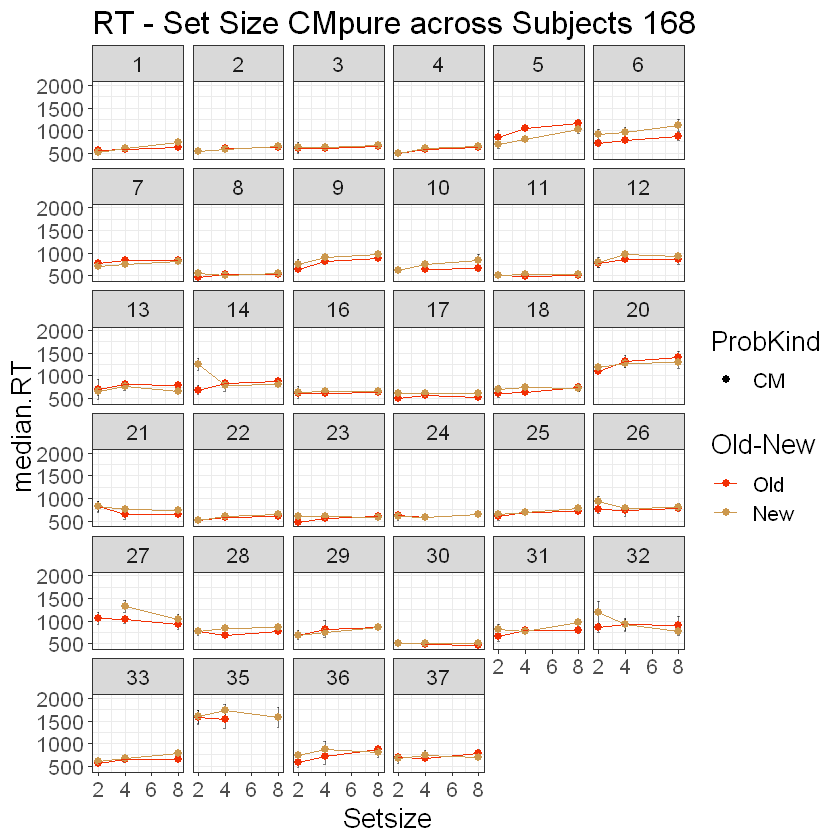

Warning message:
"Removed 21 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



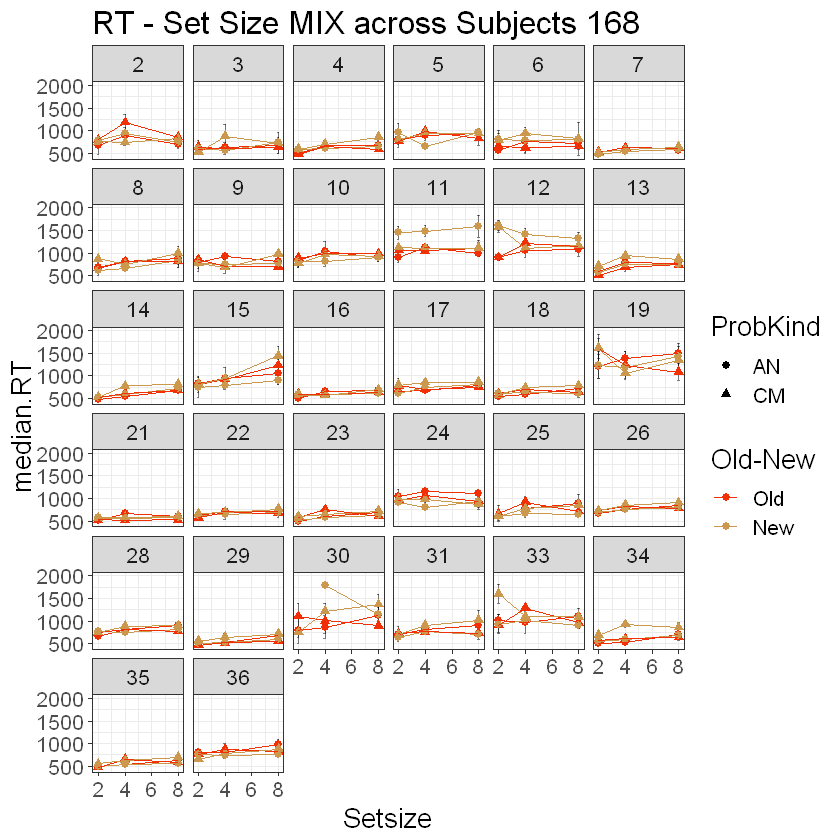

Warning message:
"Removed 10 rows containing missing values (geom_errorbar)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


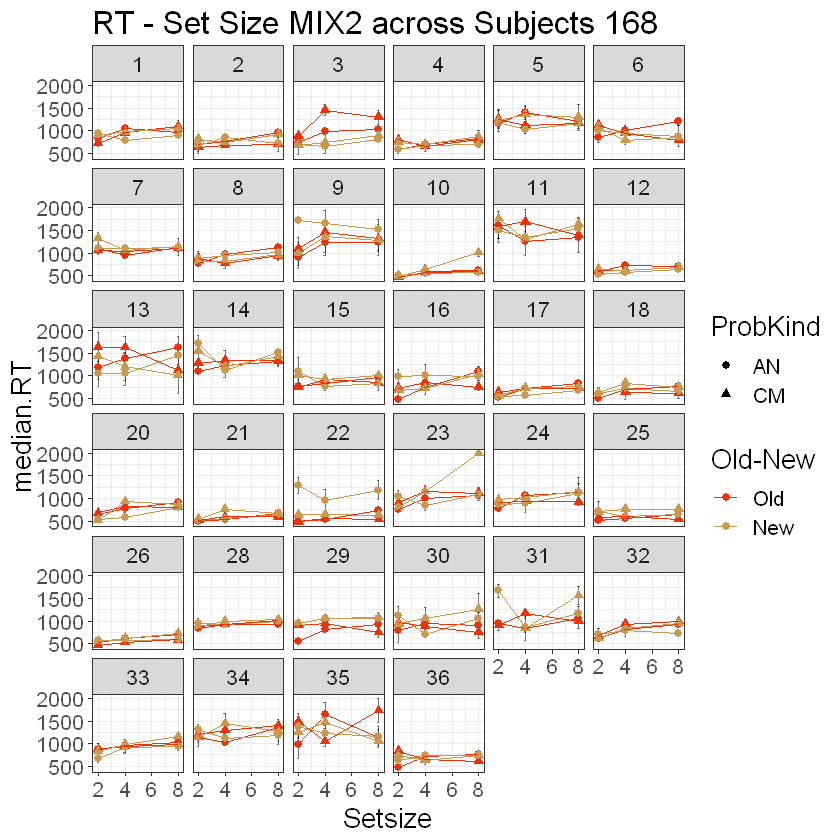

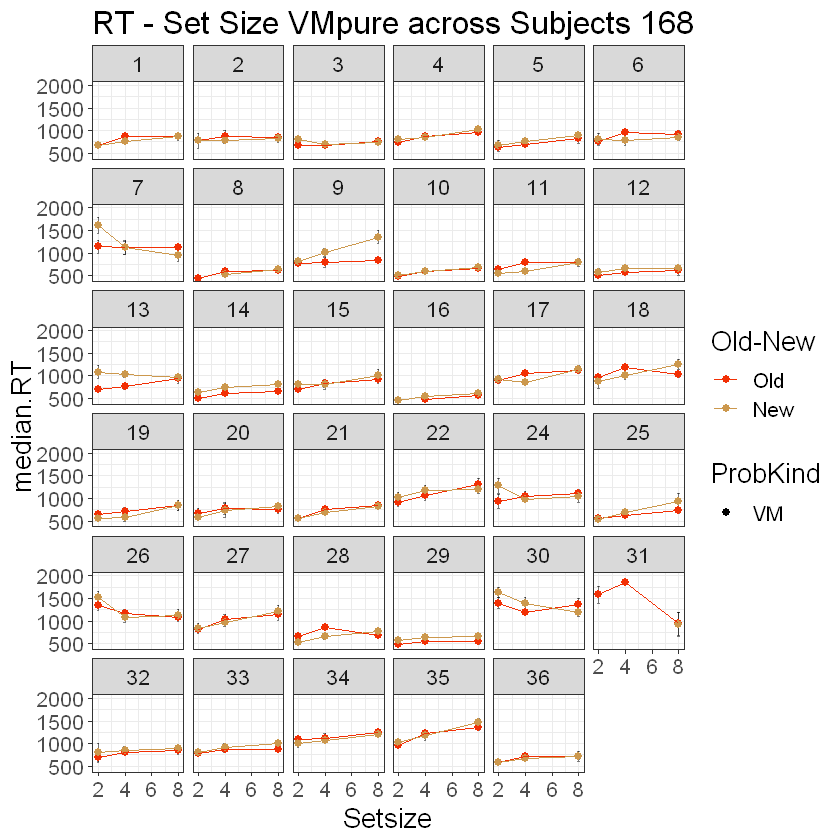

In [9]:
p.RTdif=function(condition,d){
  tit=paste(condition,'across Subjects',all_subnum)
  
  # condition="ANpure"
  d0= d%>% filter(FileCondi==condition)
  dase=d0 %>% group_by(Subnum,Old,Setsize,Stimkind,Correctness) %>%
    dplyr::summarise(median.RT=median(RT),se=sd(RT)/sqrt(n()))

  # print(dase)
  da1se=dase %>% filter(Correctness==1)
  p=ggplot(data=da1se,aes(Setsize,median.RT))+
    geom_errorbar(aes(ymin=(median.RT)-se, ymax=(median.RT)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=2)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("RT - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    # ylim(700,1550)+
  facet_wrap(Subnum~.)+
    scale_y_continuous("Response Time")+
    ylim(c(450,2000))
    print(p)
   return (p)
}
for( iname in levels(as.factor(d$FileCondi))){
    p.RTdif(iname,d)
}

#ANpure : 29, 34?
#CMpure: 32?
#Mix2: 11 - yeah maybe
#VMpure 31 - definatly


In [24]:
d_clean = d%>% filter(!(FileCondi=="ANpure" & Subnum==29)) %>%
    filter(!(FileCondi=="CMpure" & Subnum==32)) %>%
    filter(!(FileCondi=="MIX2" & Subnum==11) )%>%
    filter(!(FileCondi=="VMpure" & Subnum==31))


Automatically converting the following non-factors to factors: FileCondi, Old, Setsize, Stimkind

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



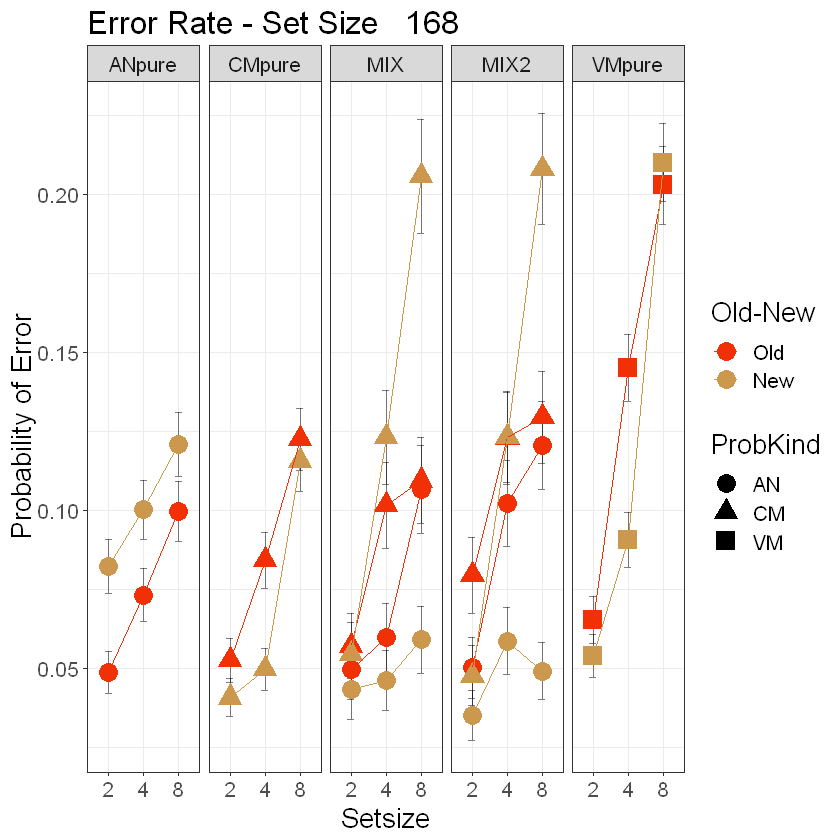

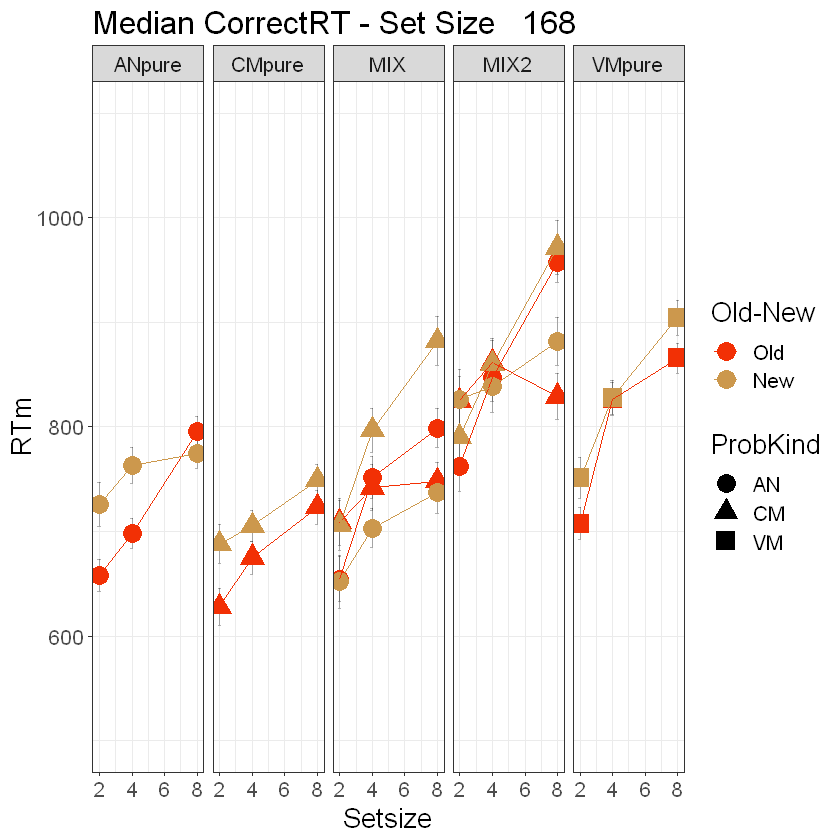

In [27]:
p.medianRT=function(d,tit,BlockFilter){
  cols <- c(`1`=1,`0`=2,`3`=3)
  
  tit=paste(' ',all_subnum," ",tit)
  dase = d %>% filter(Block %in% BlockFilter) %>%
  group_by(FileCondi,Correctness,  Old,Setsize, Stimkind) %>%
  dplyr::summarize(RTm= median(RT),
            se =sd(RT)/sqrt(n()))
  # print(dase)
  da1se=subset(dase,Correctness==1)#;da1se
  p=ggplot(data=da1se,aes(Setsize,RTm))+
    geom_errorbar(aes(ymin=RTm-se, ymax=RTm+se), width=.2,
                 position=position_dodge(.9),alpha=0.3) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=5)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Median CorrectRT - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    ylim(500,1100)+
  facet_wrap(FileCondi~.,ncol=6)
  # scale_colour_manual(name="Error Bars",values=cols, guide = guide_legend(shape = NULL,colour = NULL)) + 
  # scale_shape_manual(name="Bar",values=cols, guide="none") 
  
  return(p)
}
p.ER=function(d,tit,BlockFilter){
  tit=paste(' ',all_subnum," ",tit)
  d0= d %>% filter(Block %in% BlockFilter)
  dase=summarySEwithin(data=d0,measurevar = "Correctness",withinvars =
                         c("FileCondi","Old","Setsize","Stimkind"))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,1-Correctness))+
    geom_errorbar(aes(ymin=(1-Correctness)-se, ymax=(1-Correctness)+se), width=.2,
                 position=position_dodge(.9),alpha=0.5) +
  geom_point(aes(color=as.factor(Old),shape=as.factor(Stimkind),group=Old),size=5)+
  geom_line(aes(color=as.factor(Old),#linetype=as.factor(FileCondi),
                group=interaction(Old,Stimkind)))+
  scale_color_manual(name="Old-New",#breaks=c(1,0),
                      labels=c(`1`="Old", `2`="New"),
                      values=c("#F23005","#CC984D"))+
  scale_shape_discrete(
    name="ProbKind",labels = c(`1`="CM",`0`="AN",`3`="VM"))+
  # scale_linetype_discrete(
  #   name="Condition")+
  ggtitle(paste("Error Rate - Set Size",tit))+
     theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
  facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")
  return(p)
}
p3=p.ER(d," ",2:9)
p3
p2=p.medianRT(d," ",2:9)
p2

In [ ]:
write.csv(file="Alldata2.csv",d)
d%>%filter(FileCondi=="MIX")

In [4]:
# levels(as.factor(df_giver$FileCondi))
files = c('ANpure' ,'CMpure', 'MIX', 'MIX2', 'VMpure')
c("alpha","beta","s",paste("c",files,sep="_"),paste(rep(c("BDDo","BDDn"),5),rep(files,each=2),sep="_"),
 "t0","t0an","kappa",
 'F_ANpure_AN_oldiold_oldinew',
 'F_CMpure_CM_oldiold_oldinew',
 'L_CMpure_CM_oldiold_newinew',
 'L_CMpure_CM_oldinew_newiold',
 'F_VMpure_VM_oldiold_oldinew',
 'L_VMpure',
 'F_MIX_CM_oldiold_oldinew',
 'L_MIX_CM_oldiold_newinew',
 'L_MIX_CM_oldinew_newiold',
 'F_MIX_AN_oldiold_oldinew',
 'F_MIX2_CM_oldiold_oldinew',
 'L_MIX2_CM_oldiold_newinew',
 'L_MIX2_CM_oldinew_newiold',
 'F_MIX2_AN_oldiold_oldinew')


[1] "alpha"                       "beta"                       
 [3] "s"                           "c_ANpure"                   
 [5] "c_CMpure"                    "c_MIX"                      
 [7] "c_MIX2"                      "c_VMpure"                   
 [9] "BDDo_ANpure"                 "BDDn_ANpure"                
[11] "BDDo_CMpure"                 "BDDn_CMpure"                
[13] "BDDo_MIX"                    "BDDn_MIX"                   
[15] "BDDo_MIX2"                   "BDDn_MIX2"                  
[17] "BDDo_VMpure"                 "BDDn_VMpure"                
[19] "t0"                          "t0an"                       
[21] "kappa"                       "F_ANpure_AN_oldiold_oldinew"
[23] "F_CMpure_CM_oldiold_oldinew" "L_CMpure_CM_oldiold_newinew"
[25] "L_CMpure_CM_oldinew_newiold" "F_VMpure_VM_oldiold_oldinew"
[27] "L_VMpure"                    "F_MIX_CM_oldiold_oldinew"   
[29] "L_MIX_CM_oldiold_newinew"    "L_MIX_CM_oldinew_newiold"   
[31] "F_MIX_AN_oldiold_oldinew"    "F_MIX2_CM_oldiold_oldinew"  
[33] "L_MIX2_CM_oldiold_newinew"   "L_MIX2_CM_oldinew_newiold"  
[35] "F_MIX2_AN_oldiold_oldinew"

    for icondi in filecondis:
        x=threading.Thread(target=work_thread_p,args=(icondi,))
        threads.append(x)
        x.start()
    for icondi, thread in enumerate(threads):
        thread.join()

# Some global setting

In [3]:
global vary_ss, give_c2
vary_ss=0
give_c2=0

global nameset,is_search_allcondi_besideCMat,search_MIX1
is_search_allcondi_besideCMat=1
search_MIX1 = 0
nameset = df_org["FileCondi"].astype("category").cat.categories.to_numpy()

# ALL Parameter

In [4]:
global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L, c2
  
alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}


# boost = 1.05
alpha["all"] = 0.19
# alpha['CM'] = 0.1969 
# alpha['VM'] = 0.1969 
# alpha["AN"]=0.84

beta["all"] =1.2
# beta['CM'] = 1.228
# beta['VM'] = 1.228
# beta["AN"]= 1.708

s["all"]=0.01
s["ss24"]=0.01
s["ss8"]=0.01
# s["AN"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c["ANpure"] = 0.3938
c["CMpure"] = 0.3938
c["VMpure"] = 0.3938
c["MIX"] = 0.3938
c["MIX2"] = 0.3938
# c["CMat"] = 0.3938
c2=0.3
Old_crit["ANpure"] = 1.9197
New_crit["ANpure"] = -2.33
Old_crit["CMpure"] = 1.9197
New_crit["CMpure"] = -2.33
Old_crit["VMpure"] = 1.9197
New_crit["VMpure"] = -2.33
Old_crit["MIX"] = 1.9197
New_crit["MIX"] = -2.33
Old_crit["MIX2"] = 1.9197
New_crit["MIX2"] = -2.33

t0["all"] = 699.98
t0["ann"] =  699.98
kao = 37

#---CM
F["ANpure_AN_oldiold_oldinew"] = 0.2

F["CMpure_CM_oldiold_oldinew"] = 0.2
L["CMpure_CM_oldiold_newinew"] = 0.2
L["CMpure_CM_oldinew_newiold"] = 0

F["VMpure_VM_oldiold_oldinew"] = 0.2
L["VMpure"] = 0.2 

F["MIX_CM_oldiold_oldinew"] = 0.2
L["MIX_CM_oldiold_newinew"] = 0.2
L["MIX_CM_oldinew_newiold"] = 0.2
F["MIX_AN_oldiold_oldinew"] = 0.2

F["MIX2_CM_oldiold_oldinew"] = 0.2
L["MIX2_CM_oldiold_newinew"] = 0.2
L["MIX2_CM_oldinew_newiold"] = 0.2
F["MIX2_AN_oldiold_oldinew"] = 0.2




# Assign LTM global

In [5]:
def assign_LTM_global(Filecondi,item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    if Filecondi != "VMpure":
        if item_condi == "CM":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_CM_oldiold_oldinew"]
            else: Fnow = 0

            if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":

                Lnow = L[Filecondi+"_CM_oldiold_newinew"]
            elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":

                Lnow = L[Filecondi+"_CM_oldinew_newiold"]
            else: Lnow=0

        elif item_condi == "AN":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_AN_oldiold_oldinew"]
            else: Fnow=0

            Lnow = 0
            
        else: print("wrong condi 1",Filecondi,item_condi, walk+"i"+item)
            
    elif Filecondi == "VMpure":
        
        if item_condi == "VM":
            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
                Fnow = F["VMpure_VM_oldiold_oldinew"]
            else: Fnow = 0
        else: print("wrong condi 2")
            
        Lnow = L["VMpure"]
    else:
        print("wrong filecondi")
    
    return(Fnow + Lnow)

assign_LTM_global("MIX","AN","old","old")


0.2

# Calc A (activation)

In [6]:

def calcA(df):

    
    dnow = df
    a = np.zeros((dnow.shape[0], 8))  #activation
    

    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m = np.array([(j**(-betanow) + alphanow) for j in np.arange(1,9)])
    
    for j in range(1,9):

        indexj = j-1
            
        a[dnow["Lag"]==j,indexj] = m[indexj]
        a[dnow["Lag"]!=j,indexj] = m[indexj] * s["all"]

        
        
#         print(m[indexj] * s["all"])
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m is", np.array(m).round(3),"\n Probtype is",\
                  "\n Lag is ",dnow['Lag'].iloc[i],\
                  "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n Ai is", a[i,:].sum().round(2),\
                  "\n snow", s["all"],\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

# print(calcA(df))

A0=calcA(df)
show =[df["FileCondi"].iloc[i]+\
        "-- "+A0[i].round(5).astype(str)+\
      "--"+ df["Setsize"].iloc[i].astype(str)+\
      "--"+df["Probtype"].iloc[i]+\
      "--"+df["Oldnew"].iloc[i] for i in range(A0.size)]
print(np.sort(show))

['ANpure-- 0.01815--2--AN--new' 'ANpure-- 0.01815--2--AN--new'
 'ANpure-- 0.02652--4--AN--new' 'ANpure-- 0.02652--4--AN--new'
 'ANpure-- 0.03853--8--AN--new' 'ANpure-- 0.03853--8--AN--new'
 'ANpure-- 0.30827--8--AN--old' 'ANpure-- 0.30827--8--AN--old'
 'ANpure-- 0.32246--8--AN--old' 'ANpure-- 0.32246--8--AN--old'
 'ANpure-- 0.34194--8--AN--old' 'ANpure-- 0.34194--8--AN--old'
 'ANpure-- 0.37014--8--AN--old' 'ANpure-- 0.37014--8--AN--old'
 'ANpure-- 0.40219--4--AN--old' 'ANpure-- 0.40219--4--AN--old'
 'ANpure-- 0.4142--8--AN--old' 'ANpure-- 0.4142--8--AN--old'
 'ANpure-- 0.47953--4--AN--old' 'ANpure-- 0.47953--4--AN--old'
 'ANpure-- 0.49153--8--AN--old' 'ANpure-- 0.49153--8--AN--old'
 'ANpure-- 0.63718--2--AN--old' 'ANpure-- 0.63718--2--AN--old'
 'ANpure-- 0.64555--4--AN--old' 'ANpure-- 0.64555--4--AN--old'
 'ANpure-- 0.65755--8--AN--old' 'ANpure-- 0.65755--8--AN--old'
 'ANpure-- 1.19625--2--AN--old' 'ANpure-- 1.19625--2--AN--old'
 'ANpure-- 1.20462--4--AN--old' 'ANpure-- 1.20462--4--AN-

# Calc p (drift rate)

In [7]:
df

,Oldnew,Setsize,Probtype,Lag,Error,FileCondi,RT
,,,,,,,mean
0,new,2,AN,0,0,ANpure,816.343927
1,new,2,AN,0,0,MIX,746.881279
2,new,2,AN,0,0,MIX2,896.760000
3,new,2,AN,0,1,ANpure,801.656250
4,new,2,AN,0,1,MIX,844.000000
...,...,...,...,...,...,...,...
230,old,8,VM,6,1,VMpure,956.250000
231,old,8,VM,7,0,VMpure,971.861386
232,old,8,VM,7,1,VMpure,937.729730


In [8]:
# F["AN_oldiold_oldinew"] = 0.099
def calcp(df):
    
    A = calcA(df)
    dnow = df
    p = np.repeat(3.0, A.shape[0])
#     print(p.size)
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name

    for icondi in filecondis:
        
        #only ieterate through probs in that condition
        probs = dnow[dnow["FileCondi"]==icondi]["Probtype"].astype("category").cat.categories.to_numpy()
        for iprob in probs:

            for ion in ["old","new"]:
                    
                tf_ion = (dnow['Oldnew'] == ion)
                tf_iprob = (dnow['Probtype'] == iprob)
                tf_icondi = (dnow["FileCondi"] == icondi)
                
                tf_combi1 = np.logical_and(tf_ion, tf_iprob)
                tf_all = np.logical_and(tf_combi1,tf_icondi)

                IR_old_current = assign_LTM_global(icondi,iprob,"old",ion)
                IR_new_current = assign_LTM_global(icondi, iprob,"new",ion)
#                 print("**",icondi,iprob,"oldi"+ion+"--",IR_old_current,
#                       "newi"+ion+"--",IR_new_current)

                p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c[icondi] + IR_new_current)
#                 print(tf_all.sum(),"***")
#                 print("**",icondi,iprob,"oldi"+ion+"--",IR_old_current,
#                                       "newi"+ion+"--",IR_new_current, p[tf_all])

    return(np.array(p))


p0=calcp(df)
show =[df["FileCondi"].iloc[i]+\
       "--"+df["Probtype"].iloc[i]+\
       "--"+ df["Setsize"].iloc[i].astype(str)+\
       "--"+df["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
print(np.sort(show))


['ANpure--AN--2--new-- 0.35649' 'ANpure--AN--2--new-- 0.35649'
 'ANpure--AN--2--old-- 0.68009' 'ANpure--AN--2--old-- 0.68009'
 'ANpure--AN--2--old-- 0.78001' 'ANpure--AN--2--old-- 0.78001'
 'ANpure--AN--4--new-- 0.36517' 'ANpure--AN--4--new-- 0.36517'
 'ANpure--AN--4--old-- 0.60462' 'ANpure--AN--4--old-- 0.60462'
 'ANpure--AN--4--old-- 0.6331' 'ANpure--AN--4--old-- 0.6331'
 'ANpure--AN--4--old-- 0.68225' 'ANpure--AN--4--old-- 0.68225'
 'ANpure--AN--4--old-- 0.78103' 'ANpure--AN--4--old-- 0.78103'
 'ANpure--AN--8--new-- 0.37722' 'ANpure--AN--8--new-- 0.37722'
 'ANpure--AN--8--old-- 0.56345' 'ANpure--AN--8--old-- 0.56345'
 'ANpure--AN--8--old-- 0.57021' 'ANpure--AN--8--old-- 0.57021'
 'ANpure--AN--8--old-- 0.57916' 'ANpure--AN--8--old-- 0.57916'
 'ANpure--AN--8--old-- 0.59147' 'ANpure--AN--8--old-- 0.59147'
 'ANpure--AN--8--old-- 0.60933' 'ANpure--AN--8--old-- 0.60933'
 'ANpure--AN--8--old-- 0.63716' 'ANpure--AN--8--old-- 0.63716'
 'ANpure--AN--8--old-- 0.6853' 'ANpure--AN--8--old-- 0.68

In [9]:
# time1=time.time()

# print("time",time.time()-time1)
# p0=calcp(df)
# show =[df["FileCondi"].iloc[i]+\
#        "--"+df["Probtype"].iloc[i]+\
#        "--"+ df["Setsize"].iloc[i].astype(str)+\
#        "--"+df["Oldnew"].iloc[i]+\
#        "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
# print(np.sort(show))


dd = df[df['FileCondi']=="MIX"]
p0=calcA(dd)
show =[dd["FileCondi"].iloc[i]+\
       "--"+dd["Probtype"].iloc[i]+\
       "--"+ dd["Setsize"].iloc[i].astype(str)+\
       "--"+dd["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(p0.size)]
print(np.sort(show))

['MIX--AN--2--new-- 0.01815' 'MIX--AN--2--new-- 0.01815'
 'MIX--AN--2--old-- 0.63718' 'MIX--AN--2--old-- 0.63718'
 'MIX--AN--2--old-- 1.19625' 'MIX--AN--2--old-- 1.19625'
 'MIX--AN--4--new-- 0.02652' 'MIX--AN--4--new-- 0.02652'
 'MIX--AN--4--old-- 0.40219' 'MIX--AN--4--old-- 0.40219'
 'MIX--AN--4--old-- 0.47953' 'MIX--AN--4--old-- 0.47953'
 'MIX--AN--4--old-- 0.64555' 'MIX--AN--4--old-- 0.64555'
 'MIX--AN--4--old-- 1.20462' 'MIX--AN--4--old-- 1.20462'
 'MIX--AN--8--new-- 0.03853' 'MIX--AN--8--new-- 0.03853'
 'MIX--AN--8--old-- 0.30827' 'MIX--AN--8--old-- 0.30827'
 'MIX--AN--8--old-- 0.32246' 'MIX--AN--8--old-- 0.32246'
 'MIX--AN--8--old-- 0.34194' 'MIX--AN--8--old-- 0.34194'
 'MIX--AN--8--old-- 0.37014' 'MIX--AN--8--old-- 0.37014'
 'MIX--AN--8--old-- 0.4142' 'MIX--AN--8--old-- 0.4142'
 'MIX--AN--8--old-- 0.49153' 'MIX--AN--8--old-- 0.49153'
 'MIX--AN--8--old-- 0.65755' 'MIX--AN--8--old-- 1.21663'
 'MIX--CM--2--new-- 0.01815' 'MIX--CM--2--new-- 0.01815'
 'MIX--CM--2--old-- 0.63718' 'MIX

# RW 

In [10]:

def calc_theoretical_RW(df, which):
    
    #which = "err" or 'crt'

    A = calcA(df)
    p = calcp(df)
    q = 1-p
    
    dnow = df
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)
    pred_rt = np.zeros(p.size)

    theta1 = np.zeros(p.size)
    theta2 = np.zeros(q.size)
    theta11 = np.zeros(p.size)
    theta22 = np.zeros(q.size)
    exp_nstep = np.zeros(p.shape[0])
    
    for ifile in filecondis: 
        
        gen_tf = dnow["FileCondi"]==ifile
        AA = Old_crit[ifile]
        BB = -New_crit[ifile] # bb is a postive number
        
        if which=="crt":
            
            pq = (p[gen_tf]/q[gen_tf])
            theta1[gen_tf] = (pq**(AA+BB)+1)/(pq**(AA+BB)-1)
            theta2[gen_tf] = (pq**BB+1)/(pq**BB-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (AA/3)*(2*BB+AA)
            
            theta11[gen_tf] = (pq**(-(AA+BB))+1)/(pq**(-(AA+BB))-1)
            theta22[gen_tf] = (pq**-AA+1)/(pq**-AA-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta11[tf]*(AA+BB) - theta22[tf]*AA)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (BB/3)*(2*AA+BB)
            
#             if ifile!= "MIX" and ifile!="MIX2":
#                 pred_rt[gen_tf] = t0["all"] + kao * exp_nstep[gen_tf]

        #------------------- correct response
        elif which == "err":
            
            qp = (q[gen_tf]/p[gen_tf])
            qptfn =np.logical_and(p!=q,gen_tf)
            qptf =np.logical_and(p==q,gen_tf)

            p_resp_old[qptfn] = ((1-qp**BB)/(1-qp**(AA+BB)))[p[gen_tf]!=q[gen_tf]]
            p_resp_old[qptf] = BB/(AA+BB)
    #------------------
#     else: 
#                 print(ifile)
    if which=="crt":
        suprise = np.logical_and.reduce((np.logical_or(dnow["FileCondi"]=="MIX",dnow["FileCondi"]=="MIX2"),
                                         dnow["Probtype"]=="AN",dnow["Oldnew"]=="new"))
        notsuprise = np.logical_not(suprise)

#         pred_rt[suprise] = t0["all"] + kao * exp_nstep[suprise]
        pred_rt[suprise] = t0["ann"] + kao * exp_nstep[suprise]
        pred_rt[notsuprise] = t0["all"] + kao * exp_nstep[notsuprise]
#     for i in range(df.size):
#         print(df["FileCondi"][i],df["Probtype"][i],df["Oldnew"][i],suprise[i])

    #------------------
            
    if which == "err":
        pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
        pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]

    

    
    if which == "crt": 
        return(np.array(pred_rt))
    elif which == "err":
        return(np.array(pred_correct))
          


# time1=time.time()
# ok1=calc_theoretical_RW(df_err,"err")
# ok2=calc_theoretical_RW(df_crt,"crt")
# print(time.time()-time1)

rw_ct=calc_theoretical_RW(df,"crt")
# show =[df["FileCondi"].iloc[i]+\
#        "--"+df["Probtype"].iloc[i]+\
#        "--"+ df["Setsize"].iloc[i].astype(str)+\
#        "--"+df["Oldnew"].iloc[i]+\
#        "-- "+RW[i].round(5).astype(str) for i in range(RW.size)]
# print(np.sort(show))

# RW=calc_theoretical_RW(df,"crt")
# show =[dd["FileCondi"].iloc[i]+\
#        "--"+dd["Probtype"].iloc[i]+\
#        "--"+ dd["Setsize"].iloc[i].astype(str)+\
#        "--"+dd["Oldnew"].iloc[i]+\
#        "-- "+RW[i].round(5).astype(str) for i in range(RW.size)]
# print(np.sort(show))




## Assignvalue

In [11]:
# pd.read_csv("11_25_02_36_single_test.csv") #first good single results for mix1 
fitsel = pd.read_csv("alltry4_2_11_18_17_16.csv").iloc[:,1:] #good results for all
[alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], 
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
         L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
        fitsel.iloc[1,:].astype(float).to_list()
calc_wssd(df_err,df_crt)

NameError: name 'calc_wssd' is not defined

# Calculate WSSE

In [44]:
    [alpha["all"],beta["all"],s["all"],
            c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
            Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
            Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
            F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], 
             L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
            F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
             L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
            fitsel.iloc[4,:fitsel.shape[1]-2].astype(float).to_list()

In [54]:
w={}
# w["new_rt"] = 4*2
# w["old_rt"] = 1*2
# w["new_err"] = 4
# w["old_err"] = 1
w["new_rt"] = 1 *4 *2
w["old_rt"] = 1    *2
w["new_err"] = 1 *4 
w["old_err"] = 1 
# F["AN_oldiold_oldinew"] = 0.017
def calc_wssd(df_err,df_crt):
    
    df_sub_err = df_err.copy()
    df_sub_crt = df_crt.copy()
    pred_correct = calc_theoretical_RW(df_sub_err,"err")
    pred_crt = calc_theoretical_RW(df_sub_crt,"crt")

    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]
    
    
    adj_oldnew=0
    if adj_oldnew==1:
        print("\nERR","old",df_sub_err[df_sub_err["Oldnew"]=="old"]["wSSD_err"].sum(),\
             "new",df_sub_err[df_sub_err["Oldnew"]=="new"]["wSSD_err"].sum(),
             "\nRT","old",df_sub_crt[df_sub_crt["Oldnew"]=="old"]["wSSD_RT"].sum(),\
             "new",df_sub_crt[df_sub_crt["Oldnew"]=="new"]["wSSD_RT"].sum(),)
    #     print(df_sub_err[df_sub_err["Oldnew"]=="old"].sum() + df[df_sub_crt["Oldnew"]=="new"].sum())

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()
    
#     print(df_sub_crt)
    return(WSSD)

time1=time.time()
calc_wssd(df_err,df_crt)
# print(time.time()-time1)
# df_crtb

76.99054783493378

In [21]:
fitsel

,alpha,beta,s,c_ANpure,c_CMpure,c_MIX,c_MIX2,c_VMpure,BDDo_ANpure,BDDn_ANpure,...,F_VMpure_VM_oldiold_oldinew,L_VMpure,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew,F_MIX2_CM_oldiold_oldinew,L_MIX2_CM_oldiold_newinew,L_MIX2_CM_oldinew_newiold,F_MIX2_AN_oldiold_oldinew
0,0.1822918857459299,2.506296796094087,0.010385003166346331,0.0719853225277684,0.21708635202318477,0.33534933807224127,0.0671322664391944,0.13919254985142518,9.536829891250466,-2.1740594172842247,...,0.13698821512467058,0.00010000000000000022,0.3307983757581659,0.45585588708452657,0.16360649103987074,0.025668116128357434,0.44056862384512785,0.8415483989420757,0.47290665876839433,0.08842394472146524
1,0.1643550279016718,1.938262249132275,0.010000000052241288,0.021142659479604285,0.3381884314203202,0.17292741497138353,0.11165248178923945,0.14271584466238124,3.447900740422407,-0.7077154095663556,...,0.04215406876655004,0.006977489153899123,0.010106945056809612,0.2480377473106743,0.09255337689772372,0.00010002586904632751,0.054947542479190425,0.93782564601522,0.46180994263720515,0.043407149918671666
2,1.3423800215144777,3.6904561881996574,0.010007661127098878,0.41137769648277933,0.1964994375640952,0.7572186233571296,0.44945018200119236,0.13441552781701607,1.2185348025712481,-1.666633675735253,...,0.07891522063429242,0.00010639603263982144,0.010106258355532765,0.010230168076845727,0.00010387428113712103,0.00010000010535336589,0.025939747681074436,0.0710232317978903,0.033308002243954804,0.015936935265195316
3,0.36993750759471117,1.3489227569392737,0.02522716175739522,0.39770513111250994,0.5329886378163338,0.5787010902885843,0.3639427069207091,0.4323546908447474,3.2533024196700655,-3.3896543525090053,...,0.17326793762244078,0.0001,0.052963176380773885,0.078805795651495,0.0688057956514936,0.0001,0.17844387240782855,0.01755169438010965,0.007551694380109508,0.14036985826789747
4,0.17845851010446173,0.5530225784218766,0.027443133038744343,0.8195918768619352,0.99,0.99,0.793185807192621,0.8203098908999041,7.197545917613104,-5.359943710913685,...,0.5218769939267315,0.19977531766113607,0.4274499666823104,0.16409802436357032,0.1540980243634203,0.3732511661599037,0.6027287445455901,0.010100000003364596,0.00010000000241194982,0.5774388743930906
5,0.1 ~ 2.9,0.01 ~ 4.0,0.01 ~ 0.999,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,1.0 ~ 10.0,-10.0 ~ 1.0,...,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0


In [47]:
# pd.read_csv("11_25_02_36_single_test.csv") #first good single results for mix1 
# fitsel = pd.read_csv("11_25_04_00_single_all_try2.csv").iloc[:,1:]
for i in range(fitsel.shape[0]-1):
    [alpha["all"],beta["all"],s["all"],
            c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
            Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
            Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
            F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], 
             L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
            F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
             L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
            fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
    print(calc_wssd(df_err,df_crt))


ERR old 25.502859839033473 new 10.287711101212047 
RT old 13.59023546731962 new 27.991741948794697
77.37254835635983

ERR old 19.190594425889092 new 20.24200388760456 
RT old 18.337656986453368 new 23.490591798955297
81.2608470989023

ERR old 16.645191309999095 new 19.178672133705795 
RT old 44.34498705173632 new 26.55754085925865
106.72639135469984

ERR old 21.286020161366892 new 7.59933091817657 
RT old 47.866189571300644 new 29.058113268914354
105.80965391975846

ERR old 12.78108449210049 new 30.40783741483459 
RT old 3.499957640563601 new 3.745803121108118
50.4346826686068


# Parameter search

## Parm_dic = ... (Initialize)

In [23]:
if vary_ss==0:
     param_dic=np.array((\
        alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]))
if search_MIX1==1:
    
     param_dic=np.array((alpha["all"], beta["all"], s["all"],
                         c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                         F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                         F["MIX_AN_oldiold_oldinew"]))
         
param_dic

array([ 1.78458510e-01,  5.53022578e-01,  2.74431330e-02,  8.19591877e-01,
        9.90000000e-01,  9.90000000e-01,  7.93185807e-01,  8.20309891e-01,
        7.19754592e+00, -5.35994371e+00,  5.10518601e+00, -6.57053191e+00,
        6.17608675e+00, -6.94711550e+00,  6.14067989e+00, -6.40818530e+00,
        9.99345295e+00, -4.81229336e+00,  4.69848189e+02,  4.68612918e+02,
        1.31107858e+01,  5.11876994e-01,  5.21876994e-01,  3.38358296e-01,
        2.09775318e-01,  5.21876994e-01,  1.99775318e-01,  4.27449967e-01,
        1.64098024e-01,  1.54098024e-01,  3.73251166e-01,  6.02728745e-01,
        1.01000000e-02,  1.00000002e-04,  5.77438874e-01])

## random start

In [24]:


def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
    alpha={}; beta ={}; s = {}; F = {}; L = {}

    alpha["all"] = np.random.uniform(0.1,3)
    beta["all"] = np.random.uniform(0.01,4)
    s["all"]= np.random.uniform(0.01,0.999)
    c["ANpure"] = np.random.uniform(0.01,0.99)
    c["CMpure"] = np.random.uniform(0.01,0.99)
    c["VMpure"] = np.random.uniform(0.01,0.99)
    c["MIX"] = np.random.uniform(0.01,0.99)
    c["MIX2"] = np.random.uniform(0.01,0.99)

    Old_crit["ANpure"] = np.random.uniform(1,10)
    New_crit["ANpure"] = np.random.uniform(-10,1)
    Old_crit["CMpure"] = np.random.uniform(1,10)
    New_crit["CMpure"] = np.random.uniform(-10,1)
    Old_crit["VMpure"] = np.random.uniform(1,10)
    New_crit["VMpure"] = np.random.uniform(-10,1)
    Old_crit["MIX"] = np.random.uniform(1,10)
    New_crit["MIX"] = np.random.uniform(-10,1)
    Old_crit["MIX2"] = np.random.uniform(1,10)
    New_crit["MIX2"] = np.random.uniform(1,10)

    t0["all"] =  np.random.uniform(1,900)
    t0["ann"] =  np.random.uniform(1,900)
    kao = np.random.uniform(1,100)

    #---CM
    F["ANpure_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["CMpure_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    
    F["VMpure_VM_oldiold_oldinew"] = np.random.uniform(0.0001,1) 
    L["VMpure"] = np.random.uniform(0.0001,1) 

    F["MIX_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["MIX2_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX2_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    
    if vary_ss==0:
        param_dic=np.array((\
            alpha["all"],beta["all"],s["all"],
            c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
            Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
            Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
            F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
            F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]))
    if search_MIX1==1:

         param_dic=np.array((alpha["all"], beta["all"], s["all"],
                             c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
                             F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
                             F["MIX_AN_oldiold_oldinew"]))

    return(param_dic)

random_start()
param_dic



array([ 1.78458510e-01,  5.53022578e-01,  2.74431330e-02,  8.19591877e-01,
        9.90000000e-01,  9.90000000e-01,  7.93185807e-01,  8.20309891e-01,
        7.19754592e+00, -5.35994371e+00,  5.10518601e+00, -6.57053191e+00,
        6.17608675e+00, -6.94711550e+00,  6.14067989e+00, -6.40818530e+00,
        9.99345295e+00, -4.81229336e+00,  4.69848189e+02,  4.68612918e+02,
        1.31107858e+01,  5.11876994e-01,  5.21876994e-01,  3.38358296e-01,
        2.09775318e-01,  5.21876994e-01,  1.99775318e-01,  4.27449967e-01,
        1.64098024e-01,  1.54098024e-01,  3.73251166e-01,  6.02728745e-01,
        1.01000000e-02,  1.00000002e-04,  5.77438874e-01])

## bdd and Jacobian

In [25]:
# When search for all except CMat
if is_search_allcondi_besideCMat==1:
    bdd = (
        (0.1, 2.9),  # alpha,
        (0.01, 4),  # beta,
        (0.01, 2),  # s,
        (0.01, 10),  # c_ANpure,
        (0.01, 10),  # c_CMpure,
        (0.01, 10),  # c_MIX,
        (0.01, 10),  # c_MIX2,
        (0.01, 10),  # c_VMpure,
        (1, 10),  # BDDo_ANpure,
        (-10, 1),  # BDDn_ANpure,
        (1, 10),  # BDDo_CMpure,
        (-10, 1),  # BDDn_CMpure,
        (1, 10),  # BDDo_MIX,
        (-10, 1),  # BDDn_MIX,
        (1, 20),  # BDDo_MIX2,
        (-10, 1),  # BDDn_MIX2,
        (1, 10),  # BDDo_VMpure,
        (-10, -0.1),  # BDDn_VMpure,
        (10, 900),  # t0,
        (10, 900),  # t0an,
        (1, 100),  # kappa,
        (0.0001, 4),  # F_ANpure_AN_oldiold_oldinew,
        (0.0001, 4),  # F_CMpure_CM_oldiold_oldinew,
        (0.0001, 10),  # L_CMpure_CM_oldiold_newinew,
        (0.0001, 4),  # L_CMpure_CM_oldinew_newiold,
        (0.0001, 4),  # F_VMpure_VM_oldiold_oldinew,
        (0.0001, 4),  # L_VMpure,
        (0.0001, 4),  # F_MIX_CM_oldiold_oldinew,
        (0.0001, 4),  # L_MIX_CM_oldiold_newinew,
        (0.0001, 4),  # L_MIX_CM_oldinew_newiold,
        (0.0001, 4),  # F_MIX_AN_oldiold_oldinew,
        (0.0001, 10),  # F_MIX2_CM_oldiold_oldinew,
        (0.0001, 4),  # L_MIX2_CM_oldiold_newinew,
        (0.0001, 4),  # L_MIX2_CM_oldinew_newiold,
        (0.0001, 4)  # F_MIX2_AN_oldiold_oldinew
          )


    def Jcstrain():
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0,  0,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 1, 0, 0, -1,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 1, 0, -1,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1,  0,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 1, -1,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 0,  0,  0, 0, 1, -1,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  1, 0,  0, -1, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 0,  0,  0, 1, 0,  0, -1],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, -1, 0,  0,  0, 1, 0,  0,  0]],\
            [0.01, 0.01,0.01, 0.01,0.01, 0.01,0.01, 0.01,0.01],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])

        return(linear_constraint)
    
if search_MIX1==1:
    bdd = (
        (0.01, 2.9),  # alpha,
        (0.01, 4),  # beta,
        (0.01, 2),  # s,
#         (0,0),  # ----------------------c_ANpure,
#         (0,0),  # ----------------------c_CMpure,
        (0.01, 2),  # c_MIX,
#         (0,0),  # ----------------------c_MIX2,
#         (0,0),  # ----------------------c_VMpure,
#         (0, 0),  # ----------------------BDDo_ANpure,
#         (0, 0),  # ----------------------BDDn_ANpure,
#         (0, 0),  # ----------------------BDDo_CMpure,
#         (0, 0),  # ----------------------BDDn_CMpure,
        (1, 10),  # BDDo_MIX,
        (-10, 1),  # BDDn_MIX,
#         (0, 0),  # ----------------------BDDo_MIX2,
#         (0, 0),  # ----------------------BDDn_MIX2,
#         (0, 0),  # ----------------------BDDo_VMpure,
#         (0, 0),  # ----------------------BDDn_VMpure,
        (10, 900),  # t0,
        (10, 900),  # t0an,
        (5, 100),  # kappa,
#         (0,0),  # ----------------------F_ANpure_AN_oldiold_oldinew,
#         (0,0),  # ----------------------F_CMpure_CM_oldiold_oldinew,
#         (0,0),  # ----------------------L_CMpure_CM_oldiold_newinew,
#         (0,0),  # ----------------------L_CMpure_CM_oldinew_newiold,
#         (0,0),  # ----------------------F_VMpure_VM_oldiold_oldinew,
#         (0,0),  # ----------------------L_VMpure,
        (0.0001, 2),  # F_MIX_CM_oldiold_oldinew,
        (0.0001, 2),  # L_MIX_CM_oldiold_newinew,
        (0.0001, 2),  # L_MIX_CM_oldinew_newiold,
        (0.0001, 2),  # F_MIX_AN_oldiold_oldinew,
#         (0,0),  # ----------------------F_MIX2_CM_oldiold_oldinew,
#         (0,0),  # ----------------------L_MIX2_CM_oldiold_newinew,
#         (0,0),  # ----------------------L_MIX2_CM_oldinew_newiold,
#         (0,0)  # ----------------------F_MIX2_AN_oldiold_oldinew
          )


    def Jcstrain():
#         linear_constraint = LinearConstraint(\
#             [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0, 0, 0, 0, 0],
#              [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1, 0, 0, 0, 0]],\
#             [0.01, 0.01],[np.inf,np.inf])
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],
                                             [0.01, 0.01],[np.inf,np.inf])
                                             
        return(linear_constraint)
    

In [26]:

# def apply_sum_constraint(inp):
    
#     global alpha, beta, s, c ,Old_crit ,New_crit ,\
#         t0 ,kao , F, L, c2

#     alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}

#     [alpha["all"],beta["all"],s["all"],
#     c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
#     Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
#     Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
#     t0["all"] ,t0["ann"] ,kao,
#     F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,
#      L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
#     F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
#     F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
#     F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]
#     ] = inp
    
#     suffice = 1 
#     suffice = 1- ((np.logical_and.reduce((F["CMpure_CM_oldiold_oldinew"]>F["ANpure_AN_oldiold_oldinew"],
#                                          L["CMpure_CM_oldiold_newinew"]>L["VMpure"],
#                                          L["CMpure_CM_oldinew_newiold"]>L["VMpure"],
#                                          F["VMpure_VM_oldiold_oldinew"]>F["ANpure_AN_oldiold_oldinew"],
#                                          L["MIX_CM_oldiold_newinew"]>L["MIX_CM_oldinew_newiold"],
#                                          L["MIX2_CM_oldiold_newinew"]>L["MIX2_CM_oldinew_newiold"],
#                                          F["MIX_CM_oldiold_oldinew"]>F["MIX_AN_oldiold_oldinew"],
#                                          F["MIX2_CM_oldiold_oldinew"]> F["MIX2_AN_oldiold_oldinew"],
#                                          F["MIX2_CM_oldiold_oldinew"]> F["MIX_CM_oldiold_oldinew"]))
#     return suffice

# # cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
# my_constraints = ({'type': 'eq', "fun": apply_sum_constraint ,
#                    'jag': lambda x: np.array([[-1.0, -2.0],
# ...                                          [-2*x[0], -1.0],
# ...                                          [-2*x[0], 1.0]])})

# Actual search

In [27]:
howlong=[alpha["all"],beta["all"],s["all"],
c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
t0["all"] ,t0["ann"] ,kao,
F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]
]
len(howlong)

35

## tensorflow

In [28]:
from __future__ import print_function

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1

# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Construct model
pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

# Minimize error using cross entropy
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                          y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

ModuleNotFoundError: No module named 'tensorflow.examples.tutorials'

In [29]:
def tf_optimize():
    @tf.function
    
    
    def fn(params_dic):
        global alpha, beta, s, c ,Old_crit ,New_crit ,\
            t0 ,kao ,F, L

        alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}

        # print(params)  # <-- you'll see that params is a NumPy array
        if vary_ss==0:
            [alpha["all"],beta["all"],s["all"],
            c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
            Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
            Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
            F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
            F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]]\
            = params_dic

        return calc_wssd(df_err,df_crt)
#         return tfp.math.value_and_gradient(lambda x: rosenbrock(x, a, b), x)
#     return tfp.optimizer.bfgs_minimize(fn, init, max_iterations=100)
    return tfp.optimizer.lbfgs_minimize(fn,random_start())

start = time.time()
opt = tf_optimize()
end = time.time()

# solution = tf.stack([a, tf.square(a)], axis=-1)
# solution

OperatorNotAllowedInGraphError: in converted code:

    <ipython-input-17-0270fcc00776>:13 fn  *
        [alpha["all"],beta["all"],s["all"],
    C:\Users\naszh\.conda\envs\Lea\lib\site-packages\tensorflow_core\python\framework\ops.py:547 __iter__
        self._disallow_iteration()
    C:\Users\naszh\.conda\envs\Lea\lib\site-packages\tensorflow_core\python\framework\ops.py:540 _disallow_iteration
        self._disallow_when_autograph_enabled("iterating over `tf.Tensor`")
    C:\Users\naszh\.conda\envs\Lea\lib\site-packages\tensorflow_core\python\framework\ops.py:518 _disallow_when_autograph_enabled
        " decorating it directly with @tf.function.".format(task))

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did not convert this function. Try decorating it directly with @tf.function.


In [30]:
def fn(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    if vary_ss==0:
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] = params_dic
    

    return calc_wssd(df_err,df_crt)

optim_wsse(param_dic)

0.14055488511349692

## optim_wsse (apply calc_wssd)

In [51]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    if search_MIX1!=1:
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], 
         F["MIX2_AN_oldiold_oldinew"]] = params_dic
        
        df_sub_err = df_err.copy()
        df_sub_crt = df_crt.copy()
        
    if search_MIX1==1:
        [alpha["all"],beta["all"],s["all"],
        c["MIX"] ,
        Old_crit["MIX"] ,New_crit["MIX"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"],
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"]]\
        = params_dic
        

        df_sub_err = df_err[df_err["FileCondi"]=="MIX"]
        df_sub_crt = df_crt[df_crt["FileCondi"]=="MIX"]
    
        df_sub_err=df_sub_err.reset_index()
        df_sub_crt=df_sub_crt.reset_index()
    return calc_wssd(df_sub_err,df_sub_crt)

optim_wsse(param_dic)


ERR old 0.15389137374132653 new 0.12157020433039709 
RT old 0.31165199334393173 new 0.07666502382176821


0.6637785952374236

## Write file (optimize method)

In [33]:
def actual_search_trust3():# 

    time1 = time.time()
    numit=15
    global fitted_params3,result
    fitted_params3 = np.zeros((numit,np.array(bdd).shape[0]))
    for i in range(0,numit):
        param_dic = random_start()
#         result = optimize.minimize(optim_wsse, param_dic,\
#                                bounds=bdd,options={'verbose': 1,"maxiter" : 800},
#                                    constraints=[Jcstrain(), ],
#                                    method='trust-constr')
        result = optimize.minimize(optim_wsse, param_dic,\
                       bounds=bdd,options={"maxiter" : 800},
                           constraints=[Jcstrain(), ])
        print(i)
        print("time:", time.time()-time1)
        print(result)
        if result.success:
            fitted_params3[i,:] = result.x
        else: 
            print(result.message)


    time2 = time.time()
    print(time2-time1)
# actual_search_trust3()

## actual write file**

In [160]:
result.x

array([ 4.28420416e-01,  4.39034029e-01,  1.63625457e-02,  4.20011747e+00,
        5.62975694e+00,  5.69252688e+00,  8.15712585e-01,  4.12714917e+00,
        3.68231684e+00, -1.33718103e+00,  4.17511175e+00, -7.99183492e+00,
        5.78564426e+00, -6.27790976e+00,  3.95369375e+00, -4.24023553e+00,
        5.79598526e+00, -5.06265938e+00,  1.82021366e+02,  2.33078487e+02,
        5.25971748e+01,  6.82245379e-01,  2.98720514e+00,  3.34728309e+00,
        2.77259006e+00,  2.80547901e+00,  9.75584150e-01,  3.53733142e-01,
        1.33616134e-01,  1.23588501e-01,  2.83395583e-01,  9.20802649e+00,
        2.59521726e+00,  1.21710741e+00,  1.88929897e+00])

In [64]:
actual_search_trust3()

def write_file(which_work):
    
    if vary_ss==0:
        Parnames = ['alpha','beta','s','c_ANpure','c_CMpure','c_MIX','c_MIX2','c_VMpure',
        'BDDo_ANpure','BDDn_ANpure','BDDo_CMpure','BDDn_CMpure','BDDo_MIX','BDDn_MIX',
        'BDDo_MIX2','BDDn_MIX2','BDDo_VMpure','BDDn_VMpure','t0','t0an','kappa',
        'F_ANpure_AN_oldiold_oldinew','F_CMpure_CM_oldiold_oldinew','L_CMpure_CM_oldiold_newinew',
        'L_CMpure_CM_oldinew_newiold','F_VMpure_VM_oldiold_oldinew','L_VMpure','F_MIX_CM_oldiold_oldinew',
        'L_MIX_CM_oldiold_newinew','L_MIX_CM_oldinew_newiold','F_MIX_AN_oldiold_oldinew',
        'F_MIX2_CM_oldiold_oldinew','L_MIX2_CM_oldiold_newinew','L_MIX2_CM_oldinew_newiold','F_MIX2_AN_oldiold_oldinew']
    if search_MIX1==1:
        Parnames = ['alpha','beta','s','c_MIX',
        'BDDo_MIX','BDDn_MIX','t0','t0an','kappa',
        'F_MIX_CM_oldiold_oldinew',
        'L_MIX_CM_oldiold_newinew','L_MIX_CM_oldinew_newiold','F_MIX_AN_oldiold_oldinew']
    
    fitted_params3
    fitpdf=pd.DataFrame(fitted_params3)
    fitpdf.columns=Parnames
    now = datetime.now()
    current_time = now.strftime("%m_%d_%H_%M")
    fitsel=fitpdf[fitpdf["alpha"]>0]
    #------
    bddstr=np.array(bdd).astype(str)
    bddbdd=pd.DataFrame([[bddstr[i,0]+" ~ "+bddstr[i,1] for i in range(bddstr.shape[0])]])
    bddbdd.columns=Parnames
    fitsel=fitsel.append(bddbdd, sort=False)
    #---------
    #======= write wssd
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L, c2
    wssd_all = np.zeros(fitsel.shape[0])
    if search_MIX1==1:
        for i in range(fitsel.shape[0]-1):
            [alpha["all"], beta["all"], s["all"], c, Old_crit, New_crit, t0["all"],
              t0["ann"], kao, F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"],
              L["CM_oldinew_newiold"], F["AN_oldiold_oldinew"]]=fitsel.iloc[i,:].astype(float).to_list()
            wssd_all[i]=calc_wssd(df_org)
    if search_MIX1!=1:
        for i in range(fitsel.shape[0]-1):
            [alpha["all"],beta["all"],s["all"],
            c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
            Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
            Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,
            New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
            t0["all"] ,t0["ann"] ,kao,
            F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,
            L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
            F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
            F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], 
            L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
            F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], 
            L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]]=fitsel.iloc[i,:].astype(float).to_list()
            
            wssd_all[i]=calc_wssd(df_err,df_crt)
    

    fitsel["wssd"]=wssd_all
    filen = current_time + "_" + which_work + ".csv"
    #=======
    #=====
#     w_curr=np.repeat("--------------",fitsel.shape[0])
#     w_keys = [i for i in w.keys()]
#     w_values=[i for i in w.values()]
# #     print(w_keys,w_values,w_curr,fitsel.shape[0])
#     for i in range(len(w_keys)):
#         w_curr[i]= w_keys[i]+":"+str(w_values[i])

#     fitsel["w"]=w_curr
    #===============
    
    filen = current_time + "_" + which_work + ".csv"
    
    fitsel.to_csv(filen)

    return(fitsel)
    

current = "search_all_try3(non trust_region)"

fitsel=write_file(current)
fitsel

0
time: 2118.0808992385864
     fun: 11.079941840974659
     jac: array([-6.17384911e-04,  3.22937965e-04,  4.23170328e-02,  5.69939613e-04,
        5.91278076e-05,  3.50224972e-03, -4.12225723e-04, -3.26943398e-03,
        4.77194786e-04, -8.46385956e-05, -1.04832649e-03,  3.19957733e-04,
        1.12915039e-03, -7.70092010e-05,  4.34994698e-04, -5.61714172e-04,
       -7.39097595e-06, -9.03964043e-04, -6.09159470e-05, -1.30534172e-04,
       -2.00390816e-04, -3.46899033e-05,  1.09744072e-03,  2.35331059e-03,
       -1.19662285e-03, -4.95052338e-03, -1.44910812e-03,  5.16593456e-03,
        1.65404677e-01, -1.62166238e-01, -1.24442577e-03,  8.79848003e-03,
        1.86004639e-01, -1.81110978e-01, -1.47819519e-03])
 message: 'Optimization terminated successfully.'
    nfev: 8269
     nit: 222
    njev: 221
  status: 0
 success: True
       x: array([ 4.88605397e-01,  9.75462001e-01,  1.50349812e-02,  4.39000691e-01,
        1.00000000e-02,  6.46131711e-01,  4.03721230e-01,  4.77529012e

C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


2
time: 67001.5509827137
     fun: 0.5712520114537012
     jac: array([ 2.80831754e-03, -1.55113637e-03,  4.74771112e-02,  4.00245190e-04,
       -1.01147592e-03, -1.05666369e-03, -1.40428543e-03, -1.89024210e-03,
       -9.58144665e-06,  9.48160887e-05, -6.71260059e-04,  3.68848443e-04,
       -2.36853957e-05, -2.42896378e-04,  1.03428960e-04, -3.83839011e-04,
       -2.09279358e-04, -1.45226717e-04, -9.51141119e-05, -1.81101263e-04,
       -3.73810530e-04, -1.31305084e-02,  1.25928521e-02,  5.71243465e-04,
        1.10101253e-02,  1.37882680e-03,  3.21686268e-04,  1.94320083e-03,
        1.26509152e-01, -1.25335932e-01,  1.55638158e-03,  1.57967210e-03,
        1.49673313e-01, -1.48895510e-01,  1.37363374e-03])
 message: 'Optimization terminated successfully.'
    nfev: 18069
     nit: 485
    njev: 485
  status: 0
 success: True
       x: array([ 5.89063620e-01,  8.58579779e-01,  1.37605950e-02,  5.55188324e-01,
        7.52070404e-01,  8.21752747e-01,  5.14543282e-01,  6.10672344e-

8
time: 72669.24129080772
     fun: 0.5391160713418588
     jac: array([-5.18458337e-03,  1.46069378e-03, -1.79376453e-02,  5.05149364e-06,
        5.04411757e-04,  2.36287713e-04,  2.28700787e-03,  2.31488049e-03,
        1.80348754e-04, -1.75587833e-04,  2.81289220e-04, -2.07051635e-04,
        3.77684832e-04, -4.32983041e-04,  1.19440258e-04,  2.80156732e-04,
        5.83715737e-04, -3.95216048e-04, -2.91764736e-05, -1.07958913e-05,
        9.15080309e-05, -7.10541159e-02,  7.36755133e-02, -8.23885202e-04,
        7.50038177e-02,  2.04684585e-03,  2.28234380e-03, -2.28382647e-04,
        2.09582403e-01, -2.08884642e-01,  6.00278005e-02,  9.39898193e-04,
        2.35479809e-01, -2.34267965e-01, -5.76913357e-04])
 message: 'Optimization terminated successfully.'
    nfev: 13436
     nit: 361
    njev: 361
  status: 0
 success: True
       x: array([ 4.08773975e-01,  1.20979874e+00,  1.83660795e-02,  3.63319564e-01,
        4.77941055e-01,  5.27098996e-01,  3.25351239e-01,  3.84883978e

14
time: 164400.22653865814
     fun: 0.5385320800807737
     jac: array([ 2.46046484e-03, -8.83013010e-04,  2.74241418e-02, -2.08444893e-03,
       -4.75712121e-04,  2.05047429e-04,  1.70078874e-03, -1.81397796e-03,
       -2.24269927e-04, -1.36300921e-04, -2.00346112e-04,  5.79655170e-06,
       -4.25100327e-04,  4.39852476e-04,  3.37198377e-04,  1.36300921e-04,
        1.65700912e-04, -3.16485763e-04, -2.71871686e-05, -2.41473317e-05,
        1.05053186e-06, -6.72249421e-02,  7.29064867e-02, -5.42946160e-04,
        7.29737282e-02, -2.90524215e-03, -2.70096213e-03, -5.03937155e-03,
        2.10177027e-01, -2.13185072e-01,  4.91617620e-02,  2.92771310e-03,
        2.32717410e-01, -2.31664836e-01,  1.72697008e-04])
 message: 'Optimization terminated successfully.'
    nfev: 9717
     nit: 261
    njev: 261
  status: 0
 success: True
       x: array([ 4.06658833e-01,  1.21162208e+00,  1.89586127e-02,  3.70038850e-01,
        4.85297143e-01,  5.34519737e-01,  3.30207359e-01,  3.91455127

,alpha,beta,s,c_ANpure,c_CMpure,c_MIX,c_MIX2,c_VMpure,BDDo_ANpure,BDDn_ANpure,...,L_VMpure,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew,F_MIX2_CM_oldiold_oldinew,L_MIX2_CM_oldiold_newinew,L_MIX2_CM_oldinew_newiold,F_MIX2_AN_oldiold_oldinew,wssd
0,0.488605,0.975462,0.015035,0.439001,0.01,0.646132,0.403721,0.477529,2.64296,-2.74024,...,0.0001,0.0916725,0.0615614,0.0515614,0.0356119,0.170505,0.0208302,0.0108302,0.1223,11.079942
1,0.398371,1.25149,0.0223857,0.411412,0.531648,0.583296,0.355185,0.427182,2.98069,-3.30993,...,0.0001,0.0607226,0.0829532,0.0729532,0.0001,0.161398,0.0339647,0.0239647,0.112074,0.536838
2,0.589064,0.85858,0.0137606,0.555188,0.75207,0.821753,0.514543,0.610672,2.85768,-2.89468,...,0.0001,0.149451,0.0738957,0.0638957,0.0865961,0.240325,0.0265565,0.0165565,0.186757,0.571252
3,1.55738,1.0778,0.0123479,2.32058,1.90328,3.20398,1.55507,1.69984,3.59746,-9.9972,...,0.000138014,1.32917,2.08071,1.43109,0.944574,1.33917,0.010138,0.000136902,1.2747,0.918102
4,2.33616,1.23534,0.0126062,5.02351,5.29672,5.62002,4.24867,5.46309,8.84083,-9.59281,...,0.873551,2.91812,1.20807,1.19807,2.62153,4.24693,0.560371,0.550371,4,0.799322
5,0.88318,0.844763,0.0143926,1.15342,1.56205,1.6572,1.01214,0.905229,4.66229,-4.31575,...,0.0184193,0.504645,0.205581,0.195581,0.382061,0.627091,0.0527199,0.0427199,0.53026,0.629035
6,0.387839,1.11019,0.0266252,0.519065,1.38857,0.723034,0.413065,0.513939,3.54659,-3.95182,...,0.0001,0.0814325,0.133076,0.123076,0.0001,0.223621,0.0643149,0.0543149,0.158298,0.575907
7,1.93369,0.949849,0.0117766,2.77501,3.74997,3.91378,1.76296,2.28883,6.62237,-5.38694,...,0.0001,0.977638,0.999678,0.989678,0.395071,1.37529,2.34323,1.94783,0.838728,0.771092
8,0.408774,1.2098,0.0183661,0.36332,0.477941,0.527099,0.325351,0.384884,2.64221,-2.84248,...,0.000100001,0.0543547,0.0606293,0.0506293,0.0001,0.131036,0.0227938,0.0127938,0.0853893,0.539116
9,1.14218,1.72098,0.01,0.640147,0.405972,1.58238,0.341861,0.3168,6.17012,-2.64581,...,0.131734,0.868275,1.10686,0.408485,0.0001,3.27031,4,1.01218,0.419278,17.236773


## Well Present of parameters

In [28]:
for i in range(fitsel.shape[0]-1):
    print(str(i)+"---------")
    for j in range(fitsel.shape[1]):
        print(fitsel.columns[j],fitsel.iloc[i,j])

0---------
alpha 0.4080033440801831
beta 0.9344654881178697
s 0.04014594686203528
c_ANpure 0.5266239262521863
c_CMpure 0.8606095618999478
c_MIX 0.9015991205050569
c_MIX2 0.6105916863282149
c_VMpure 0.17865770604252898
BDDo_ANpure 1.952919669026918
BDDn_ANpure -5.028845794449412
BDDo_CMpure 3.809001427812757
BDDn_CMpure -0.18865820508468722
BDDo_MIX 6.020103838524824
BDDn_MIX -0.8662929270826805
BDDo_MIX2 4.787082627471988
BDDn_MIX2 -6.169054854233559
BDDo_VMpure 7.997933216934124
BDDn_VMpure 1.0
t0 543.2146990809421
t0an 622.1375660367461
kappa 14.163455741691442
F_ANpure_AN_oldiold_oldinew 0.16569231857795683
F_CMpure_CM_oldiold_oldinew 0.361721049575192
L_CMpure_CM_oldiold_newinew 0.6296092101047972
L_CMpure_CM_oldinew_newiold 0.2890813000309461
F_VMpure_VM_oldiold_oldinew 0.6502069881565956
L_VMpure 0.09268725460296551
F_MIX_CM_oldiold_oldinew 0.11306961706689606
L_MIX_CM_oldiold_newinew 0.3114350778394627
L_MIX_CM_oldinew_newiold 0.3014350778377479
F_MIX_AN_oldiold_oldinew 0.0001
F

In [208]:
fitsel

,alpha,beta,s,c_ANpure,c_CMpure,c_MIX,c_MIX2,c_VMpure,BDDo_ANpure,BDDn_ANpure,...,F_VMpure_VM_oldiold_oldinew,L_VMpure,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew,F_MIX2_CM_oldiold_oldinew,L_MIX2_CM_oldiold_newinew,L_MIX2_CM_oldinew_newiold,F_MIX2_AN_oldiold_oldinew
3,0.287552,0.813666,0.01,0.21591,0.0100135,0.242173,0.189554,0.190815,1.2876,-1.80631,...,0.0101004,0.000100201,0.0113971,0.0122585,0.00225709,0.000100089,0.0213978,0.0101056,0.000100645,0.000100125
4,0.870904,0.543731,0.0103847,0.807176,0.0330781,0.0131061,0.0864005,0.0695043,1.03549,-4.15751,...,0.899522,0.00284793,0.228762,0.781791,0.0462772,0.0127073,0.398059,0.839107,0.0335515,0.0111781
0,0.1 ~ 3.0,0.01 ~ 4.0,0.01 ~ 0.999,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,1.0 ~ 10.0,-10.0 ~ 1.0,...,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0


In [147]:
OP={}
OP["ANpure_AN_oldiold_oldinew"]=1 
OP["CMpure_CM_oldiold_oldinew"]=1 
OP["CMpure_CM_oldiold_newinew"]=1 
OP["CMpure_CM_oldinew_newiold"]=1 

OP["VMpure_VM_oldiold_oldinew"]=1 
OP["VMpure"]=1

OP["MIX_CM_oldiold_oldinew"]=1
OP["MIX_CM_oldiold_newinew"]=1
OP["MIX_CM_oldinew_newiold"]=1
OP["MIX_AN_oldiold_oldinew"]=1

OP["MIX2_CM_oldiold_oldinew"]=1
OP["MIX2_CM_oldiold_newinew"]=1
OP["MIX2_CM_oldinew_newiold"]=1
OP["MIX2_AN_oldiold_oldinew"]=1

[ikey for ikey in OP.keys()]

['ANpure_AN_oldiold_oldinew',
 'CMpure_CM_oldiold_oldinew',
 'CMpure_CM_oldiold_newinew',
 'CMpure_CM_oldinew_newiold',
 'VMpure_VM_oldiold_oldinew',
 'VMpure',
 'MIX_CM_oldiold_oldinew',
 'MIX_CM_oldiold_newinew',
 'MIX_CM_oldinew_newiold',
 'MIX_AN_oldiold_oldinew',
 'MIX2_CM_oldiold_oldinew',
 'MIX2_CM_oldiold_newinew',
 'MIX2_CM_oldinew_newiold',
 'MIX2_AN_oldiold_oldinew']

In [133]:
fitted_params3


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
script_7162030730439011880 in <module>
----> fitted_params3
      

NameError: name 'fitted_params3' is not defined


## Assignresults

In [44]:
 [alpha["all"],beta["all"],s["all"],
c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
t0["all"] ,t0["ann"] ,kao,
F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
    fitted_params3[0]
#     [ 2.69059123e-01,  1.01173807e+00,  1.00000000e-02,
#          2.47324636e-01,  1.74913690e-01,  2.73909878e-01,
#          1.47916292e-01,  1.37776461e-01,  1.19239059e+00,
#         -2.37981688e+00,  1.65526545e+00, -1.58246249e+00,
#          1.19671695e+00, -1.73485235e+00,  2.01573662e+00,
#         -1.62492720e+00,  2.12811898e+00, -1.43638672e+00,
#          1.00000000e+00,  1.00000000e+00,  5.00000000e+00,
#          1.00000000e-04,  1.01000000e-02,  8.40294889e-02,
#          1.01000000e-02,  1.01000000e-02,  1.00000000e-04,
#          1.82072853e-02,  2.01208968e-02,  1.01208968e-02,
#          1.00000000e-04,  2.82072853e-02,  1.14222443e-02,
#          1.42224429e-03,  1.00000000e-04]#     fitted_params3[0]

NameError: name 'fitted_params3' is not defined

# Final Random Walk

In [39]:
# s_AN=0.01
# s_others = 0.07
def finalRW(df_what,kind):

    if kind == "err":
        df_what["Pred_error"] = 1-calc_theoretical_RW(df_what,kind)
    elif kind == "crt":
        df_what["Pred_cRT"]=calc_theoretical_RW(df_what,kind)
    else: print("error input of name kind")
    
    return(df_what)

if search_MIX1==1:
    df_sub=df_crt.copy()
    df_sub=df_sub[df_sub["FileCondi"]=="MIX"]

    print(finalRW(df_sub,"crt"))

## Try all plot

In [40]:
[alpha["all"],beta["all"],s["all"],
    c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
    Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
    Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
    t0["all"] ,t0["ann"] ,kao,
    F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
    F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
    F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
    F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
    [ 4.28420416e-01,  4.39034029e-01,  1.63625457e-02,  4.20011747e+00,
        5.62975694e+00,  5.69252688e+00,  8.15712585e-01,  4.12714917e+00,
        3.68231684e+00, -1.33718103e+00,  4.17511175e+00, -7.99183492e+00,
        5.78564426e+00, -6.27790976e+00,  3.95369375e+00, -4.24023553e+00,
        5.79598526e+00, -5.06265938e+00,  1.82021366e+02,  2.33078487e+02,
        5.25971748e+01,  6.82245379e-01,  2.98720514e+00,  3.34728309e+00,
        2.77259006e+00,  2.80547901e+00,  9.75584150e-01,  3.53733142e-01,
        1.33616134e-01,  1.23588501e-01,  2.83395583e-01,  9.20802649e+00,
        2.59521726e+00,  1.21710741e+00,  1.88929897e+00]

df_crt_pred = finalRW(df_crt,"crt")
df_err_pred = finalRW(df_err,"err")

all_plot(df_crt_pred,"Pred_cRT",(500,2000))
# all_plot(df_crt_pred,"RT",(5,2000))
all_plot(df_err_pred,"Pred_error",(0,0.3))
# all_plot(df_err,"Error",(0,0.3))

NameError: name 'all_plot' is not defined

## True all_plot

In [41]:
def all_plot(df_all,plotwhaty,ylim):
    df_all_err = df_all.copy()
    df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
    df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
    df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1])

#     df_all_aggnew.index.name = 'Setsize'
    df_all_aggnew.reset_index(inplace=True)
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    plt.figure()
#     plt.title(plotwhaty)
    for iname in names:
        
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1
    
    plt.show()
    plt.close()   

## read fitsel from csv

In [115]:
# pd.read_csv("11_25_02_36_single_test.csv") #first good single results for mix1 
fitsel = pd.read_csv("11_25_06_50_search_all_try2_changewdds.csv").iloc[:,1:] #good results for all

In [116]:
fitsel

,alpha,beta,s,c_ANpure,c_CMpure,c_MIX,c_MIX2,c_VMpure,BDDo_ANpure,BDDn_ANpure,...,F_VMpure_VM_oldiold_oldinew,L_VMpure,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew,F_MIX2_CM_oldiold_oldinew,L_MIX2_CM_oldiold_newinew,L_MIX2_CM_oldinew_newiold,F_MIX2_AN_oldiold_oldinew
0,0.5626131674198283,0.620305899922724,0.02314184051328097,0.5464080996949993,0.34298717407993085,0.5387269294556017,1.4657632486190442,0.19639066802846092,3.6005685215005347,-9.21937946900508,...,2.6152220066788403,0.10413523217433925,1.0240690633723981,0.23991445781679147,0.22991445781679146,0.9336427221254886,3.3072400628717324,2.890010169853424,1.1145648761724738,0.26141923613106277
1,1.321528367161568,0.8235384569021894,0.020065243641154723,0.4093669325183765,0.06114300585113614,0.6829022925366903,1.9999999999999991,0.6948242199517055,3.3710100661193856,-6.870359930742685,...,0.6896852876428459,0.28387289917818037,1.3786917929047875,2.0565303324200146,1.8002952636962652,0.9103216120433231,3.6162530145522873,0.8641681837230427,0.8345543374962198,0.5777951751975566
2,0.1 ~ 2.9,0.01 ~ 4.0,0.01 ~ 2.0,0.01 ~ 2.0,0.01 ~ 2.0,0.01 ~ 2.0,0.01 ~ 2.0,0.01 ~ 2.0,1.0 ~ 10.0,-10.0 ~ 1.0,...,0.0001 ~ 4.0,0.0001 ~ 4.0,0.0001 ~ 4.0,0.0001 ~ 4.0,0.0001 ~ 4.0,0.0001 ~ 4.0,0.0001 ~ 4.0,0.0001 ~ 4.0,0.0001 ~ 4.0,0.0001 ~ 4.0


## real try **

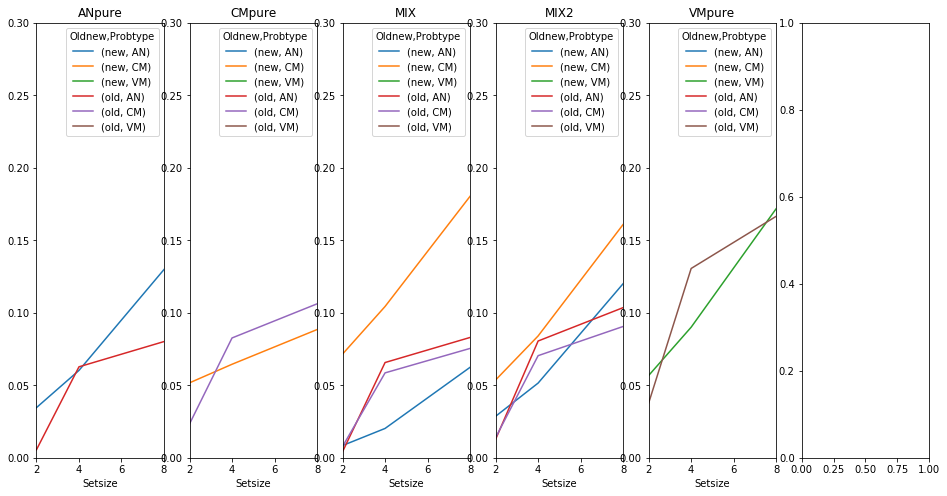

<Figure size 432x288 with 0 Axes>

0


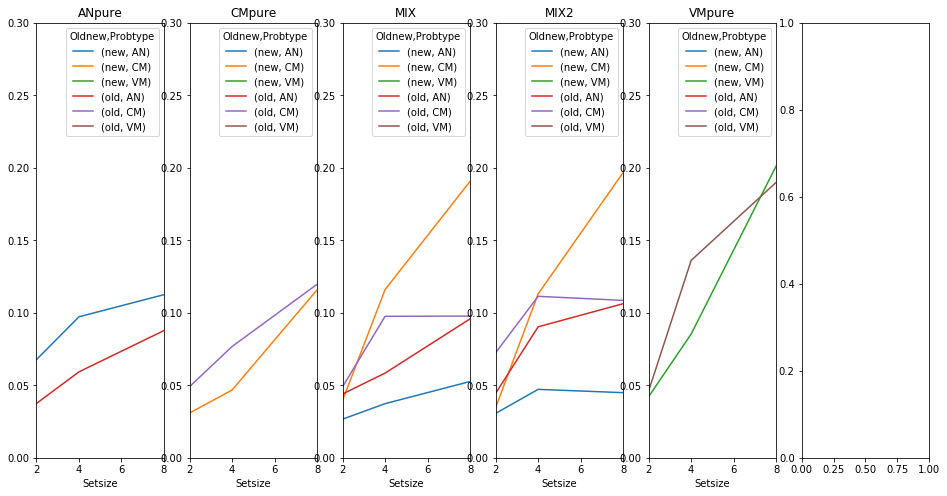

<Figure size 432x288 with 0 Axes>

In [59]:
for i in range(fitsel.shape[0]-1):
    
    if search_MIX1!=1:
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], 
         L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"],
         L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
        fitsel.iloc[i,:fitsel.shape[1]-1].astype(float).to_list()
        
        df_crt_pred = finalRW(df_crt,"crt")
        df_err_pred = finalRW(df_err,"err")
        
#     elif search_MIX1==1:
#         [alpha["all"], beta["all"], s["all"],
#          c["MIX"], Old_crit["MIX"], New_crit["MIX"], t0["all"],t0["ann"], kao,
#          F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"],
#          F["MIX_AN_oldiold_oldinew"]]=\
#         fitsel.iloc[i,:fitsel.shape[1]-2].astype(float).to_list()
        
        
#         df_crt_sub=df_crt.copy()
#         df_crt_sub=df_crt_sub[df_crt_sub["FileCondi"]=="MIX"]
#         df_err_sub=df_err.copy()
#         df_err_sub=df_err_sub[df_err_sub["FileCondi"]=="MIX"]
        
#         df_crt_pred = finalRW(df_crt_sub,"crt")
#         df_err_pred = finalRW(df_err_sub,"err")


#     all_plot(df_crt_pred,"Pred_cRT",(500,2000))
#     all_plot(df_crt_pred,"RT",(5,2000))
    all_plot(df_err_pred,"Pred_error",(0,0.3))
    if i==fitsel.shape[0]-2:
        print(i)
        all_plot(df_err,"Error",(0,0.3))

0


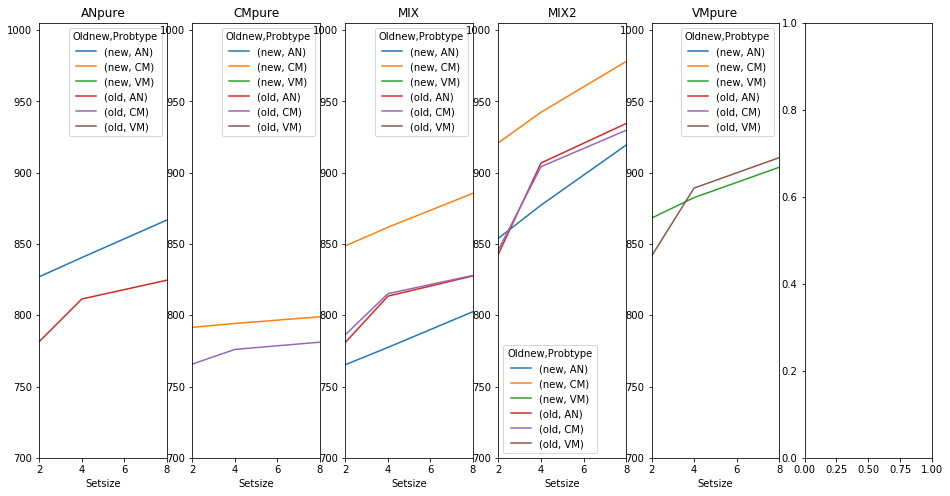

<Figure size 432x288 with 0 Axes>

0


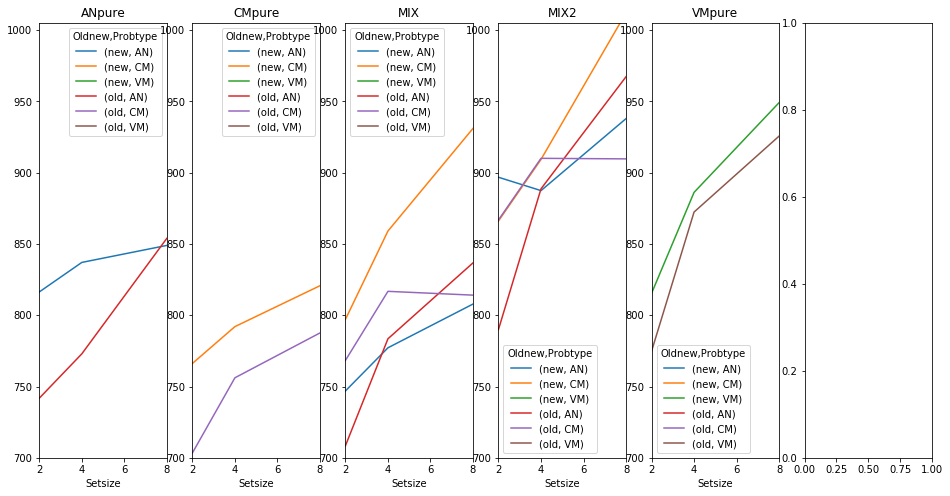

<Figure size 432x288 with 0 Axes>

In [63]:
for i in range(fitsel.shape[0]-1):
    [alpha["all"],beta["all"],s["all"],
c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
t0["all"] ,t0["ann"] ,kao,
F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
    fitsel.iloc[i,:fitsel.shape[1]-1].astype(float).to_list()
    df_crt_pred = finalRW(df_crt,"crt")
    df_err_pred = finalRW(df_err,"err")
    
    print(i)
    all_plot(df_crt_pred,"Pred_cRT",(700,1005))
#     all_plot(df_crt_pred,"RT",(5,2000))
#     all_plot(df_err_pred,"Pred_error",(0,0.3))
    if i==fitsel.shape[0]-2:
        print(i)
        all_plot(df_crt_pred,"RT",(700,1005))

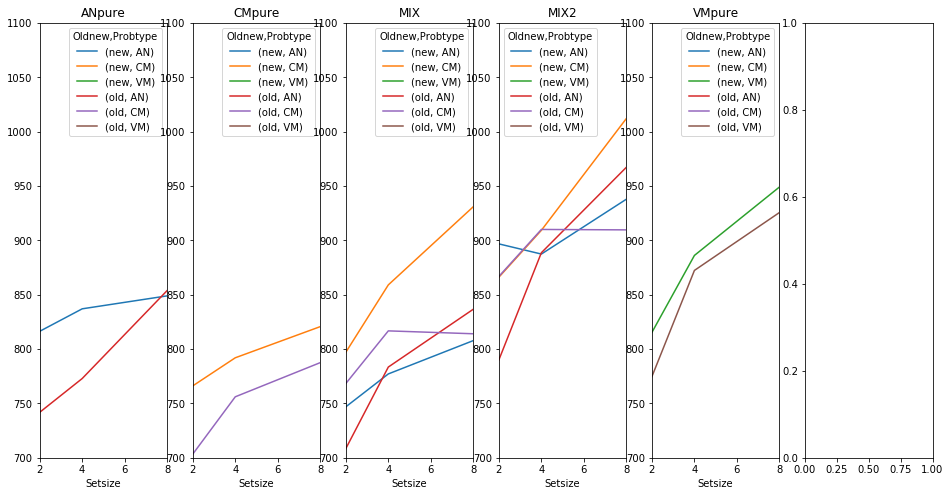

<Figure size 432x288 with 0 Axes>

In [50]:
all_plot(df_crt_pred,"Pred_cRT",(700,1100))
all_plot(df_crt_pred,"RT",(700,1100))

In [224]:
source("functions_fromr.r")

In [361]:
%get df_crt_pred --from Python3
%get df_err_pred --from Python3
%get df0 --from Python3

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


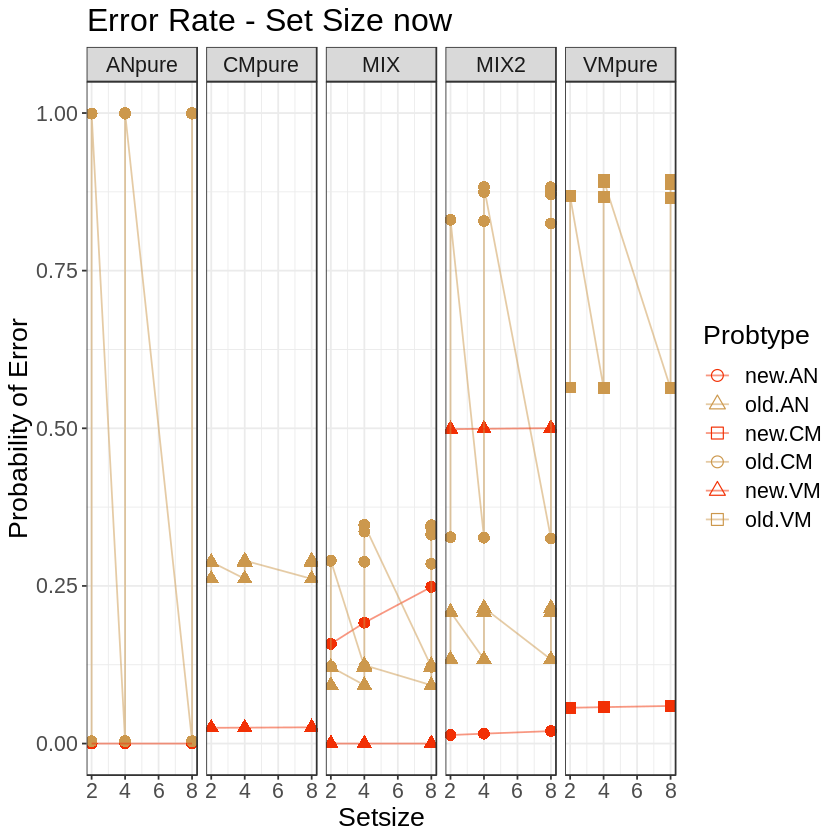

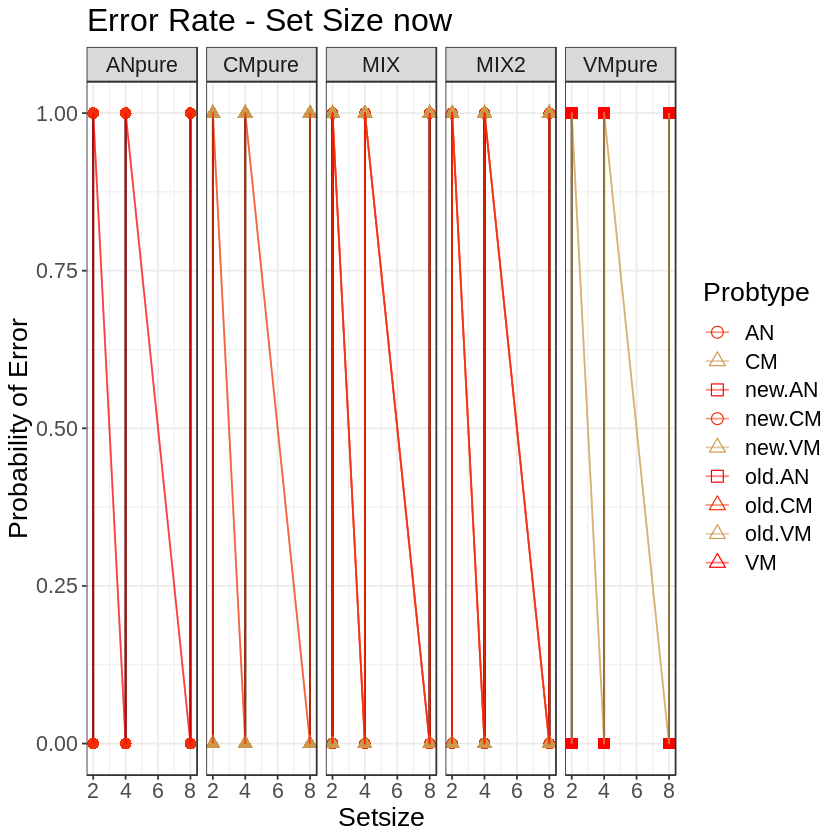

In [382]:
p.ER.pred=function(d,tit){
    override.shape = c(1,2,0,1,2,0)
  p=ggplot(data=d,aes(Setsize,Pred_error))+
    geom_point(aes(color=interaction(Oldnew,Probtype),shape=as.factor(Probtype),group=Oldnew),size=3)+
      geom_line(aes(color=interaction(Oldnew,Probtype),#linetype=as.factor(FileCondi),
                    group=interaction(Oldnew,Probtype)),lwd=0.5,alpha=0.5)+
      scale_color_manual(name="Probtype",
                         values=c(rep(c("#F23005","#CC984D"),3)))+
    scale_shape_discrete(guide=FALSE)+
    ggtitle(paste("Error Rate - Set Size",tit))+
    theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
    guides(colour = guide_legend(override.aes=list(shape=override.shape)))+
    facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")
  return(p)
}
p.ER.org=function(d,tit){
    override.shape = c(1,2,0,1,2,0,2,2,2)
  d0= d 
  dase= d %>% group_by(FileCondi,Oldnew,Setsize,Probtype,Correctness) %>%
    dplyr::summarize(Error=mean(Correctness),se=sd(Correctness)/sqrt(n()))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,Error))+
    geom_errorbar(aes(ymin=(Error-se), ymax=(1-Correctness)+se), width=.2,
                  position=position_dodge(.9),alpha=0.5) +
    geom_point(aes(color=Probtype,shape=as.factor(Probtype),group=Oldnew),size=3)+
      geom_line(aes(color=interaction(Oldnew,Probtype),#linetype=as.factor(FileCondi),
                    group=interaction(Oldnew,Probtype)),lwd=0.5,alpha=0.5)+
      scale_color_manual(name="Probtype",
                         values=c(rep(c("#F23005","#CC984D","red"),3)))+
    scale_shape_discrete(guide=FALSE)+
    ggtitle(paste("Error Rate - Set Size",tit))+
    theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
    guides(colour = guide_legend(override.aes=list(shape=override.shape)))+
    facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")#+
#     coord_fixed(ratio=0.08)
  return(p)
}
p.ER.pred(df_err_pred,"now")
p.ER.org(df0,"now")